<a href="https://colab.research.google.com/github/ccg-esb/EvK/blob/main/py_pOXA48_SI4_pairwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
import csv
import sys
import matplotlib.pyplot as plt
import colorcet as cc
import time
import multiprocessing
import random
from tabulate import tabulate
import pickle
import math
from scipy.integrate import trapz

## __SI:__ Antimicrobial resistance level and conjugation permissiveness shape plasmid distribution in clinical enterobacteria

### 4. Computer experiments: Pair-wise competition experiments

In this Jupyter Notebook, we investigate the competitive dynamics between different bacterial strains, specifically _Klebsiella spp._ and _E. coli_, under a variety of selective pressures induced by antibiotics. Our objective is to computationally map the antibiotic resistance fitness landscape within a mixed bacterial population and discern which strain exhibits superior competitive fitness under different drug concentrations.

To achieve this, here we simulate the dynamics of plasmid populations for pairs of bacterial strains, each under a different antibiotic concentration. These simulations generate quantitative data on how bacterial populations evolve over time, thus providing valuable insights into the competitive fitness of each strain under various antibiotic pressures. Through these experiments, we aim to enhance our understanding of bacterial competition dynamics and antibiotic resistance.


### Experimental parameters

In [4]:
sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *
from pOXA48_S3 import *

%run src/pOXA48_parameters
print_expe_params(expe_params)


Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-10 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------


### Model parameters

In [5]:

model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)
print("Strain Parameters")
display_model_params_stats(model_params, strains_subset)


Strain Parameters
╒═════════╤═════════════╤═══════════════════════╤═════════════════════════════════╤═════╕
│ Group   │ Parameter   │ Mean                  │ Range                           │ N   │
╞═════════╪═════════════╪═══════════════════════╪═════════════════════════════════╪═════╡
│ E-TC    │ conj_rate   │ nan                   │ (nan, nan)                      │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ VKm         │ 5.931e-10             │ (3.79e-10, 7.6e-10)             │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ rho         │ 948158352.0           │ (550386500.0, 1121715175.0)     │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ seg_rate    │ 0.0020000000000000005 │ (0.002, 0.002)                  │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────


Our approach involves running simulations for pairs of bacterial strains under different antibiotic concentrations. We then calculate the area under the curve (AUC) for each strain at each antibiotic concentration. The AUC serves as a measure of the combined effects of growth and survival throughout the duration of the simulation. By comparing the AUCs, we can quantify the relative fitness of different strains under different antibiotic pressures. The strain yielding the higher AUC is considered to have a higher fitness under the given drug concentration.

In [6]:
istrains = strains_subset  # List of strains

num_days = 10

runPathN="%sN%s/pairwise/"%(runPath, num_days)
if not os.path.exists(runPathN):
  os.makedirs(runPathN)

figPathN="%sN%s/pairwise/"%(figPath, num_days)
if not os.path.exists(figPathN):
  os.makedirs(figPathN)

powers = np.arange(-4.0, 22.0, 1.0)  # array of powers of two exponents
Amax_values=np.power(2.0, powers)  # calculate 2 raised to each exponent

A_values=[]
for Amax in Amax_values:
  A=Amax*np.ones(num_days) #Constant environment
  A_values.append(A)

strain_namesK = [model_params['strain_name'][i] for i in strains_subsetK]
strain_namesE = [model_params['strain_name'][j] for j in strains_subsetE]

print("K: %s"%(strain_namesK))
print("E: %s"%(strain_namesE))

max_density = 2e10 #for plotting

blue = '#129FE4'
red = '#E9666F'

type_experiment='competition'


K: ['PF_KPN01', 'PF_KPN02', 'PF_KQ01', 'PF_KPN09', 'PF_KPN10', 'PF_KPN11', 'PF_KQ04', 'PF_KPN12', 'PF_KPN14', 'PF_KPN16']
E: ['PF_EC02', 'PF_EC03', 'PF_EC07', 'PF_EC10', 'PF_EC12', 'PF_EC16', 'PF_EC19', 'PF_EC21', 'PF_EC22', 'PF_EC25']


In [7]:


def get_AUC(times_list, ys_list):
    """
    Computes the Area Under the Curve (AUC) for each simulation day for each strain.

    Parameters:
    times_list: list of lists
        Each sublist contains the time points for one simulation.
    ys_list: list of lists
        Each sublist contains the biomass densities at each time point for one simulation.

    Returns:
    AUCs: list of lists
        Each sublist contains the AUCs for each strain for one simulation day.
    """
    AUCs = []

    for day in range(len(times_list)):
        t = times_list[day]
        ys = ys_list[day]

        # Compute the AUC for each strain
        auc = trapz(ys, x=t, axis=-1)

        AUCs.append(auc)

    return AUCs


In [8]:
def run_pairwiseCompetition(model_params, strains1, strains2, As):
    """
    Run simulations of competition between pairs of strains under various drug concentrations.

    Parameters:
    model_params: dict
        Dictionary of model parameters.
    strains1: list
        List of indices of the first strains in the pairs.
    strains2: list
        List of indices of the second strains in the pairs.
    As: list
        List of drug concentrations for which to run the simulations.

    Returns:
    results: dict
        Dictionary of results. Each key is a drug concentration, and each value is a list of
        tuples where each tuple contains final bacterial densities and strain indices for one simulation.
    """

    S0 = model_params.attrs['S0']
    B0 = model_params.attrs['B0']

    results = {}

    for iA, this_A in enumerate(As):
        results_A = []

        for i, strain1 in enumerate(strains1):
            print('A=2**%s: %s vs %s '%(math.log2(np.max(this_A)), strain1, strains2))
            sim_path = "%spairwise_A%se-2_istrain%s.pkl" % (runPathN, int(np.max(this_A)*100), strain1)


            if os.path.isfile(sim_path):
                with open(sim_path, 'rb') as f:
                    res = pickle.load(f)
                print("\tLoading ", sim_path)
            else:
                res = []
                for j, strain2 in enumerate(strains2):
                    istrains_values = [strain1, strain2]
                    times_list, ys_list, strains_params_list = simulateTransfers_multistrain(model_params, istrains_values, this_A, type_experiment)
                    AUC = np.sum(get_AUC(times_list, ys_list), axis=0)/num_days
                    res.append((AUC[2:], strain1, strain2))

                with open(sim_path, 'wb') as f:
                    pickle.dump(res, f)
                print("\tSaving ", sim_path)

            results_A.append(res)

        results[iA] = results_A  # Store results for this drug concentration

    return results







Here we run simulation:

In [9]:
sim_df=run_pairwiseCompetition(model_params, strains_subsetE, strains_subsetK, A_values)



A=2**-4.0: 1 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain1.pkl
A=2**-4.0: 2 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain2.pkl
A=2**-4.0: 6 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain6.pkl
A=2**-4.0: 9 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain9.pkl
A=2**-4.0: 11 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain11.pkl
A=2**-4.0: 15 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain15.pkl
A=2**-4.0: 18 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain18.pkl
A=2**-4.0: 20 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Loading  ./runs/N10/pairwise/pairwise_A6e-2_istrain20.pkl
A=2**-4.0: 21 vs [25, 26, 29, 34, 37, 38, 39, 41, 43, 45] 
	Load

The function __plot_popStructure_strains__ generates a pie chart that depicts the structure of a population of strains in terms of their relative abundances. The radius of the pie chart is proportional to the total density of the population, capped at a maximum value.

In [10]:
def plot_popStructure_strains(densities, max_density, colors, alphas, ax):

    """
    Plot population structure of bacterial strains in a pie chart.

    This function takes in densities of various strains, maximum density value, colors corresponding to each strain,
    transparency values, and an axes object. It then creates a pie chart representing the population structure of
    different bacterial strains, with the pie's radius reflecting the total population size.

    Parameters:
    densities: list
        List of densities for each bacterial strain.
    max_density: float
        Maximum possible density, used for scaling the pie chart.
    colors: list
        List of colors to use for each strain in the pie chart.
    alphas: list
        List of alpha values (transparency) to use for each strain in the pie chart.
    ax: matplotlib.axes._subplots.AxesSubplot
        Matplotlib axes object where the pie chart will be plotted.
    """

    num_subpopulations = len(densities)

    # Convert negative densities to zero
    densities = np.maximum(densities, 0)

    # Calculate relative abundances for each subpopulation
    total_density = sum(densities)
    # If total_density is not zero, compute relative_abundances
    if total_density != 0:
        relative_abundances = [density / total_density for density in densities]
    else:
        relative_abundances = [0 for density in densities]

    # Add a small constant to prevent log(0)
    small_constant = 1e-10

    # Compute radius
    radius = (total_density + small_constant)/(max_density + small_constant)
    if radius>1:
      radius=1

    if radius< small_constant:
      radius= small_constant

    # Create the pie chart
    wedges, _ = ax.pie(relative_abundances, colors=colors, radius=radius, startangle=90)

    # Set alpha and edge color for each wedge
    for i, (wedge, alpha_val) in enumerate(zip(wedges, alphas)):
        wedge.set_alpha(alpha_val)
        wedge.set_edgecolor(colors[i])

    # Set aspect ratio to be equal so that the pie is circular
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])


0
Exporting ./figures/N10/pairwise_strains_N10_A6.25e-2.pdf


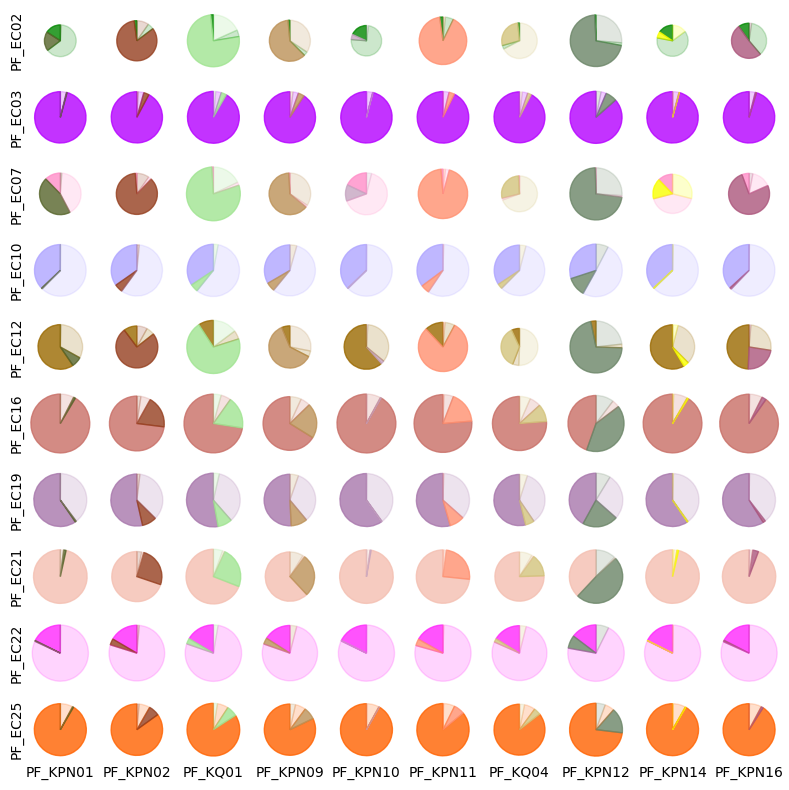

1
Exporting ./figures/N10/pairwise_strains_N10_A12.5e-2.pdf


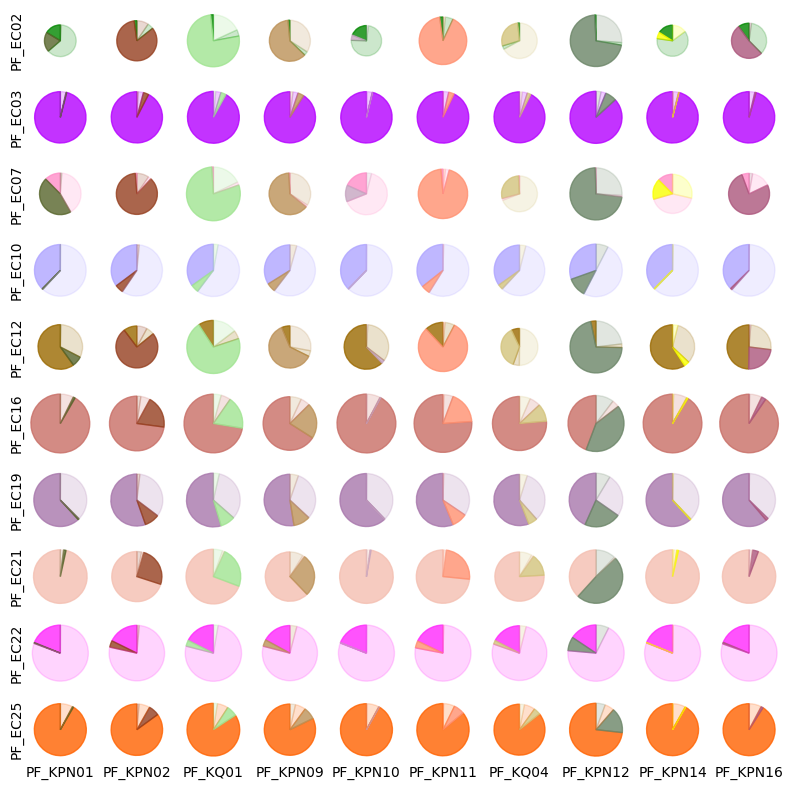

2
Exporting ./figures/N10/pairwise_strains_N10_A25.0e-2.pdf


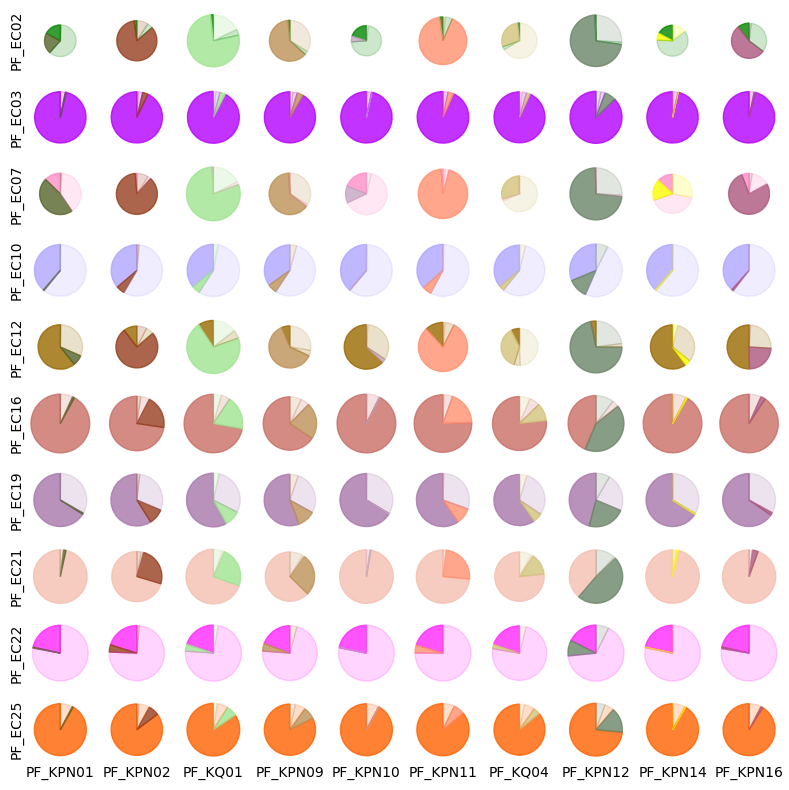

3
Exporting ./figures/N10/pairwise_strains_N10_A50.0e-2.pdf


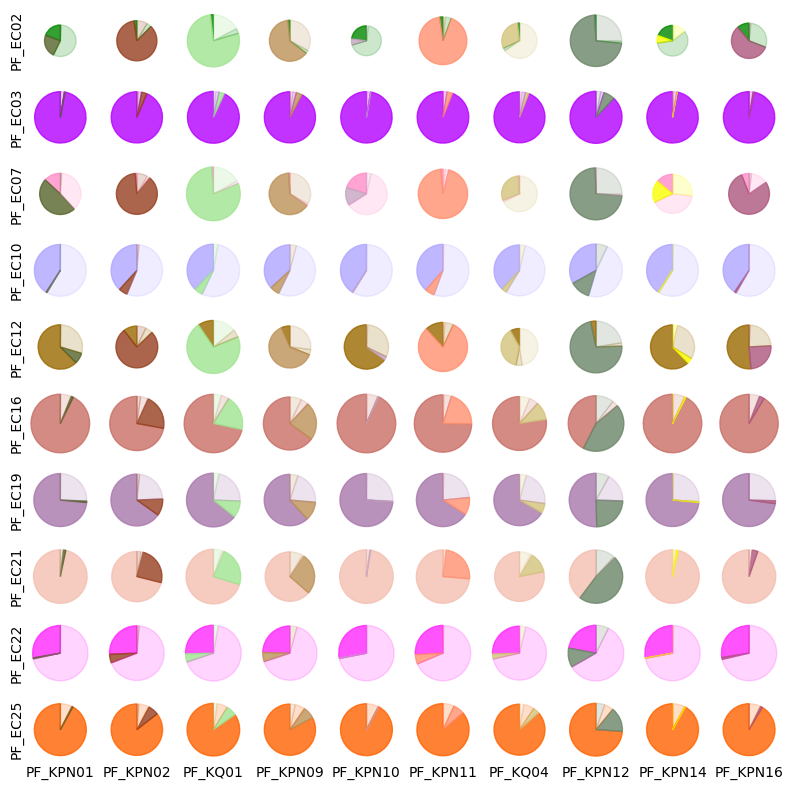

4
Exporting ./figures/N10/pairwise_strains_N10_A100.0e-2.pdf


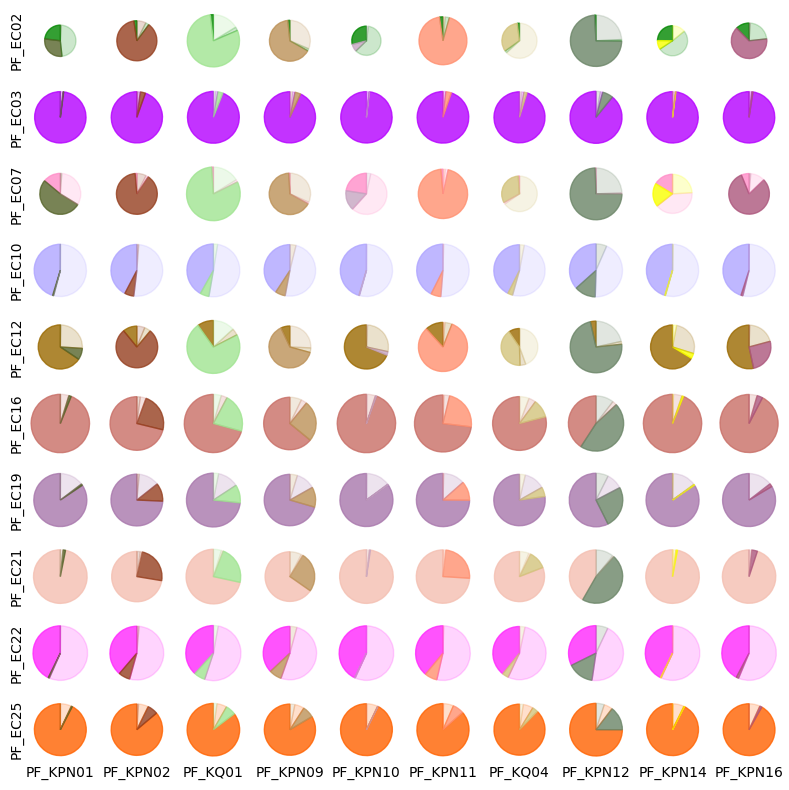

5
Exporting ./figures/N10/pairwise_strains_N10_A200.0e-2.pdf


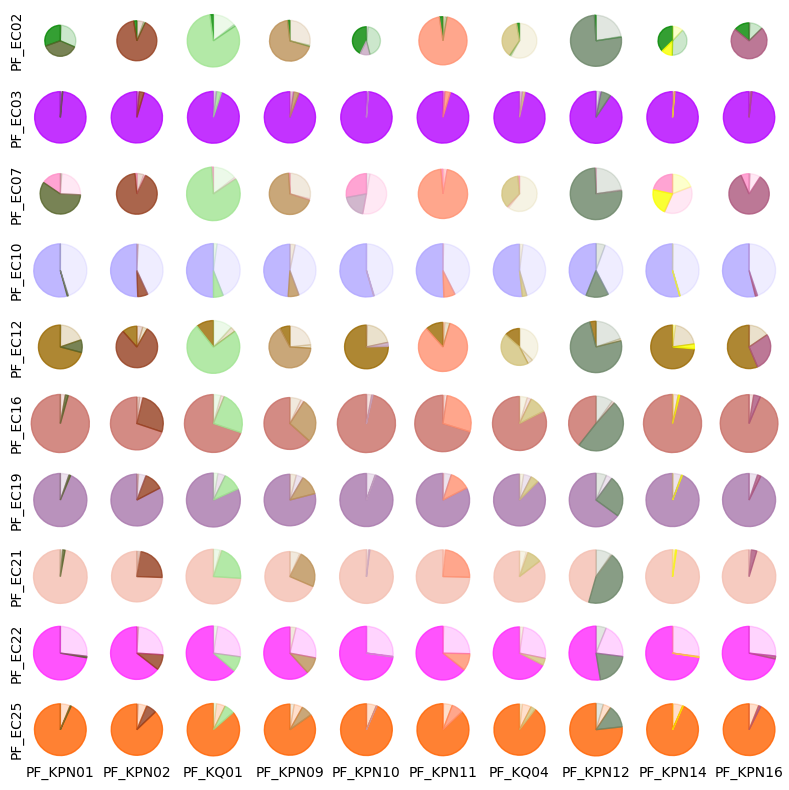

6
Exporting ./figures/N10/pairwise_strains_N10_A400.0e-2.pdf


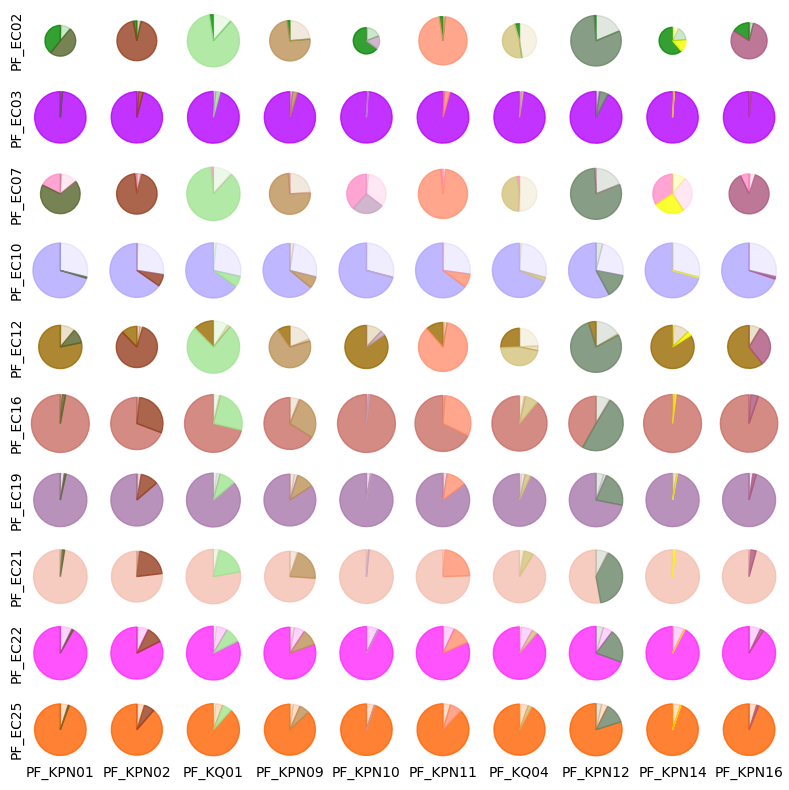

7
Exporting ./figures/N10/pairwise_strains_N10_A800.0e-2.pdf


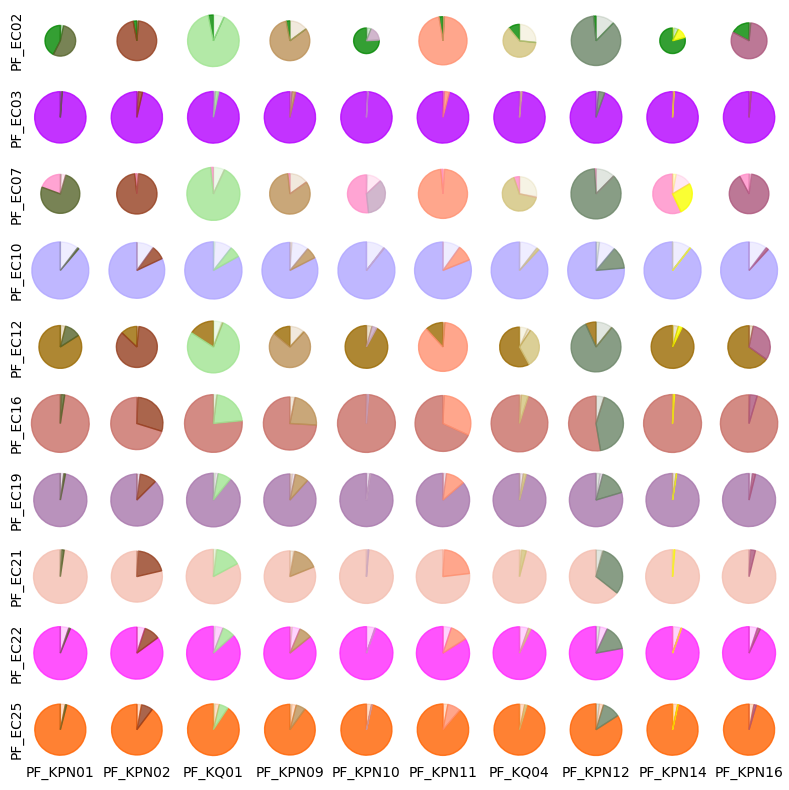

8
Exporting ./figures/N10/pairwise_strains_N10_A1600.0e-2.pdf


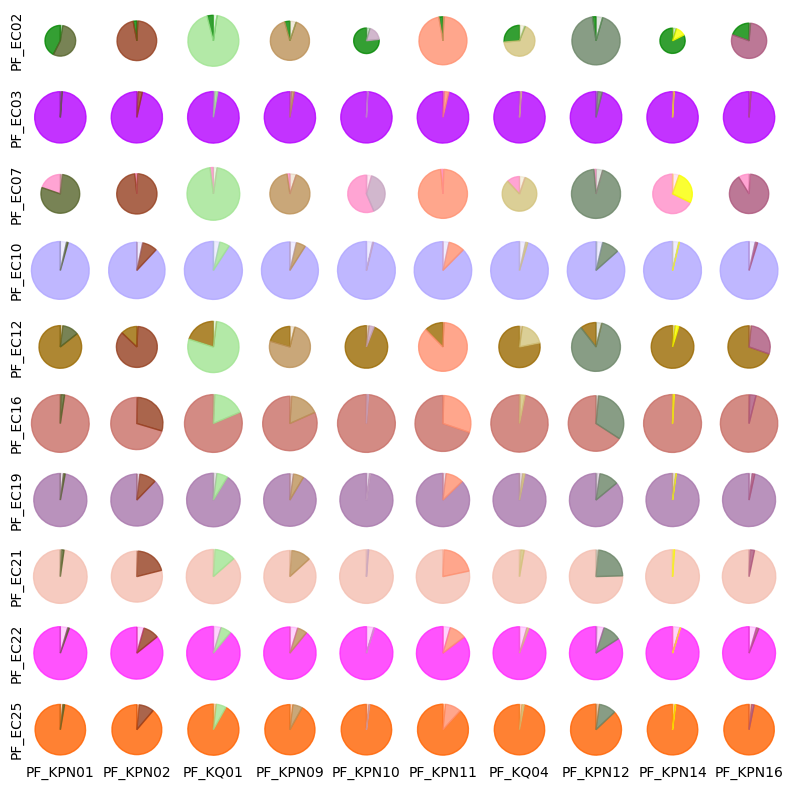

9
Exporting ./figures/N10/pairwise_strains_N10_A3200.0e-2.pdf


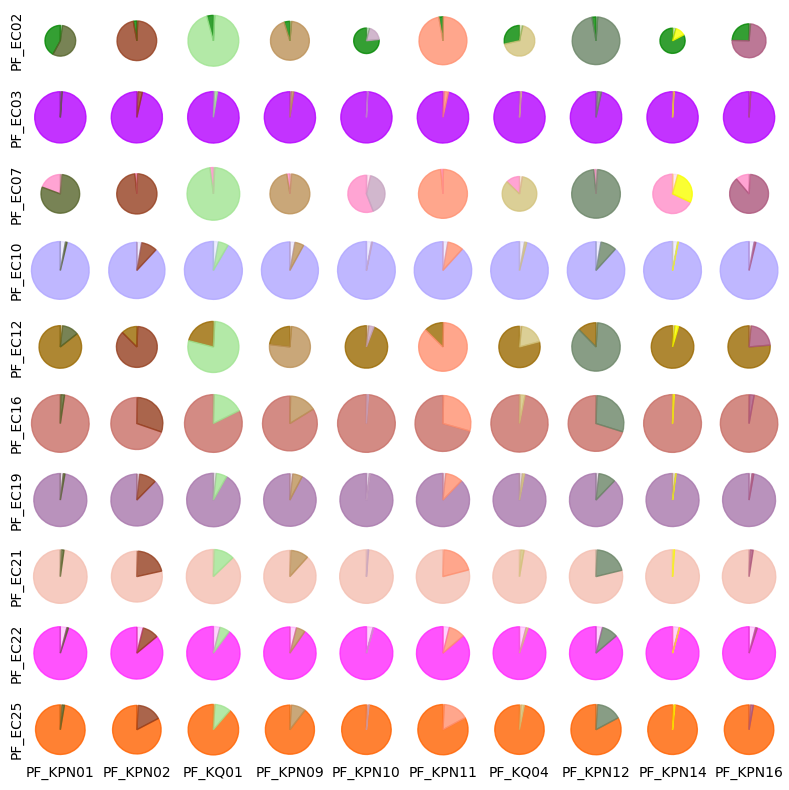

10
Exporting ./figures/N10/pairwise_strains_N10_A6400.0e-2.pdf


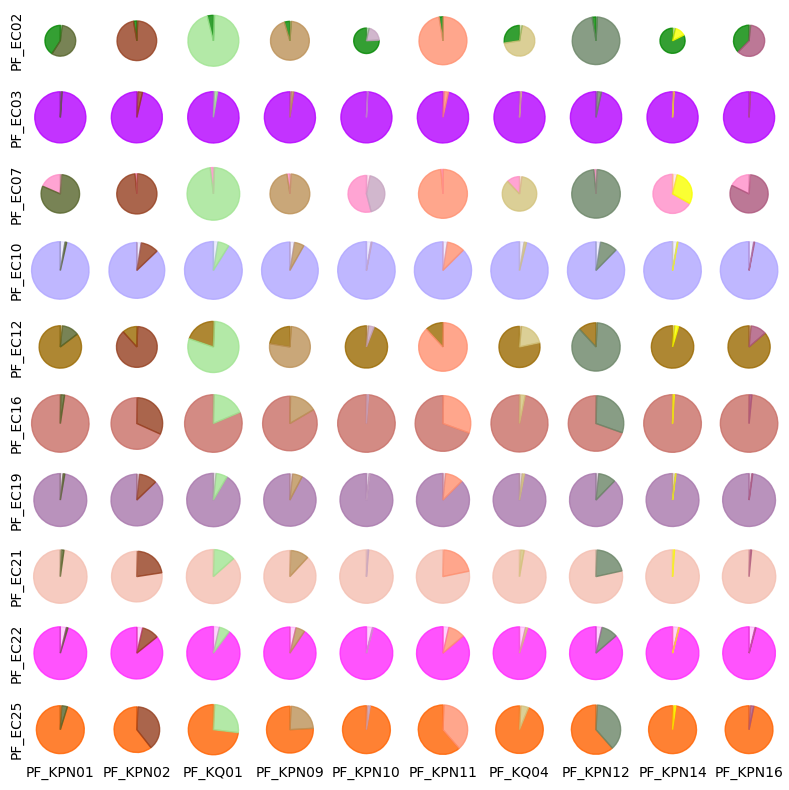

11
Exporting ./figures/N10/pairwise_strains_N10_A12800.0e-2.pdf


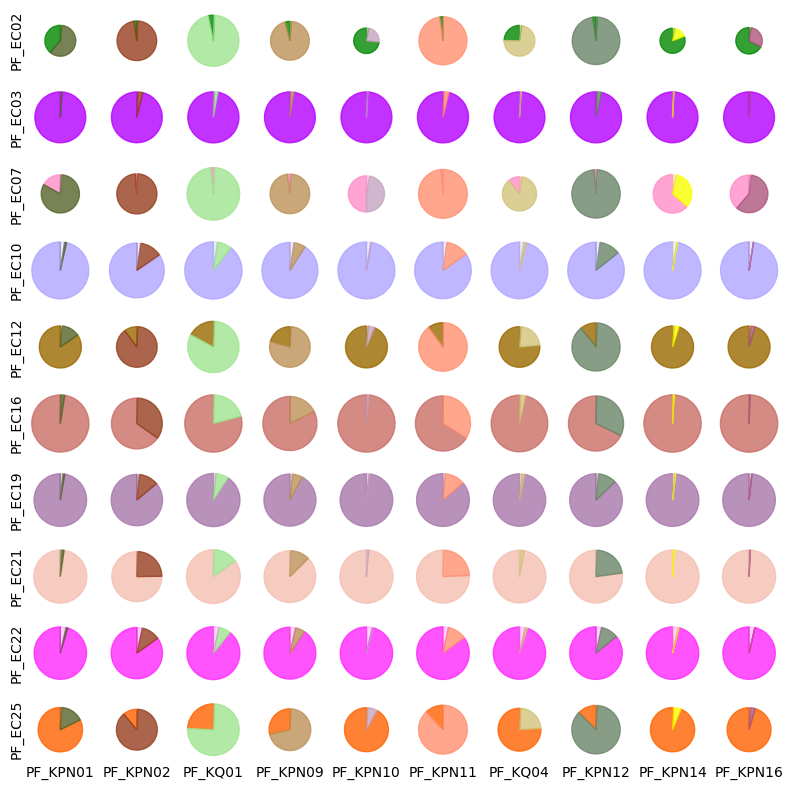

12
Exporting ./figures/N10/pairwise_strains_N10_A25600.0e-2.pdf


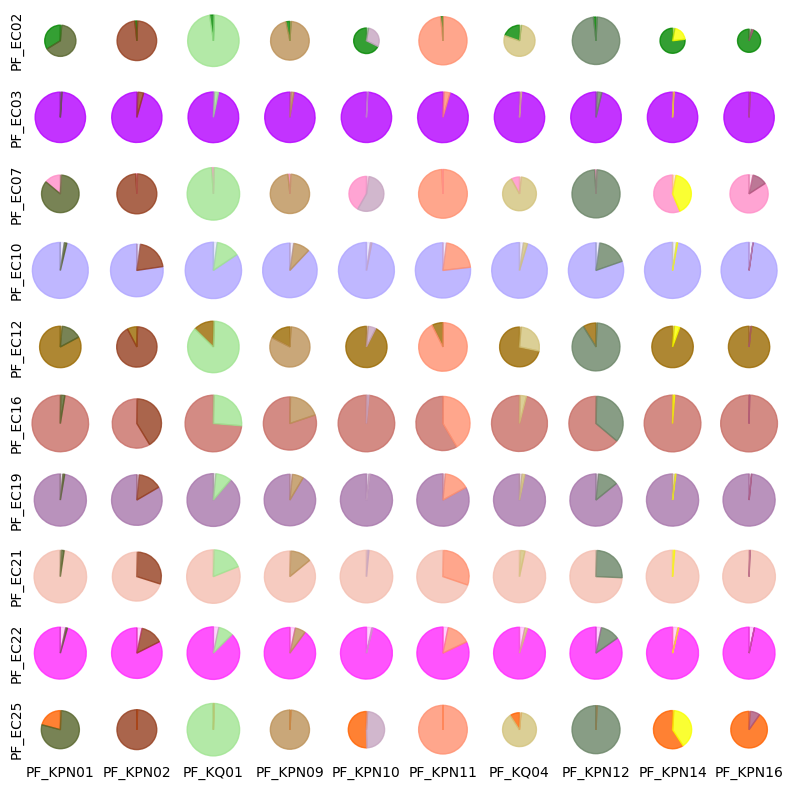

13
Exporting ./figures/N10/pairwise_strains_N10_A51200.0e-2.pdf


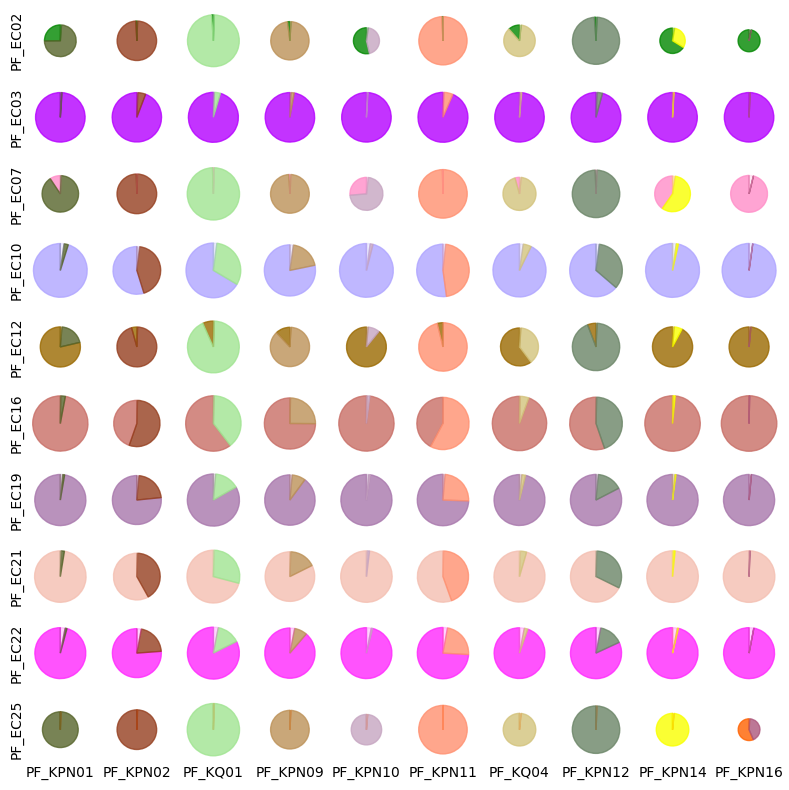

14
Exporting ./figures/N10/pairwise_strains_N10_A102400.0e-2.pdf


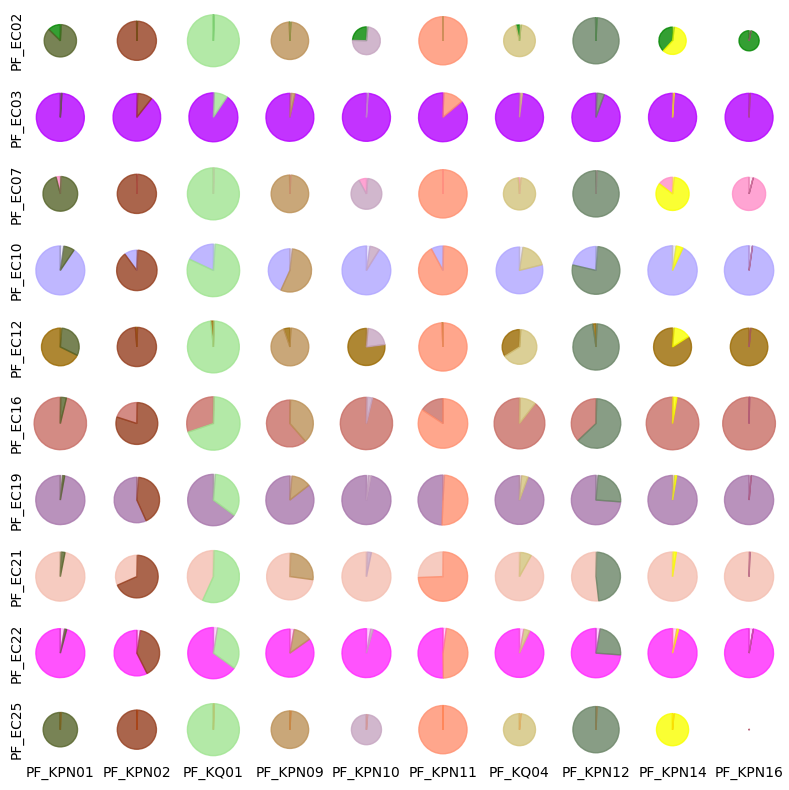

15
Exporting ./figures/N10/pairwise_strains_N10_A204800.0e-2.pdf


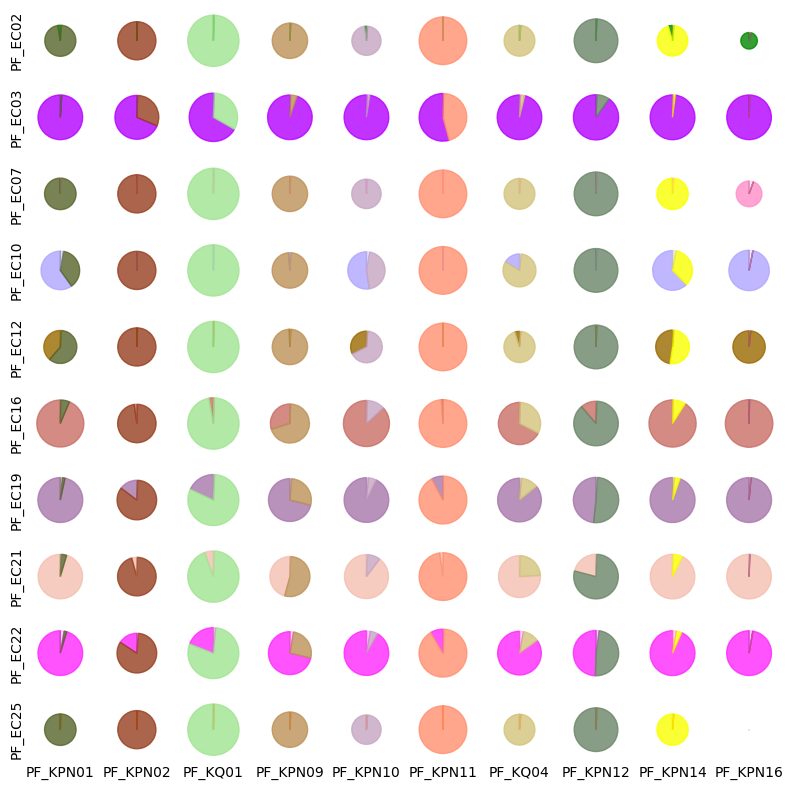

16
Exporting ./figures/N10/pairwise_strains_N10_A409600.0e-2.pdf


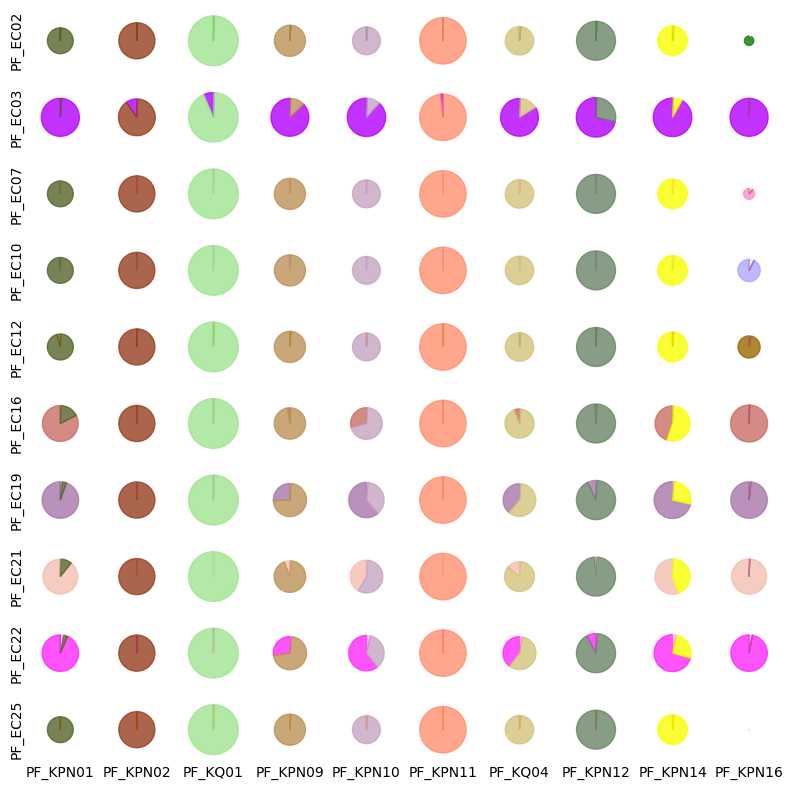

17
Exporting ./figures/N10/pairwise_strains_N10_A819200.0e-2.pdf


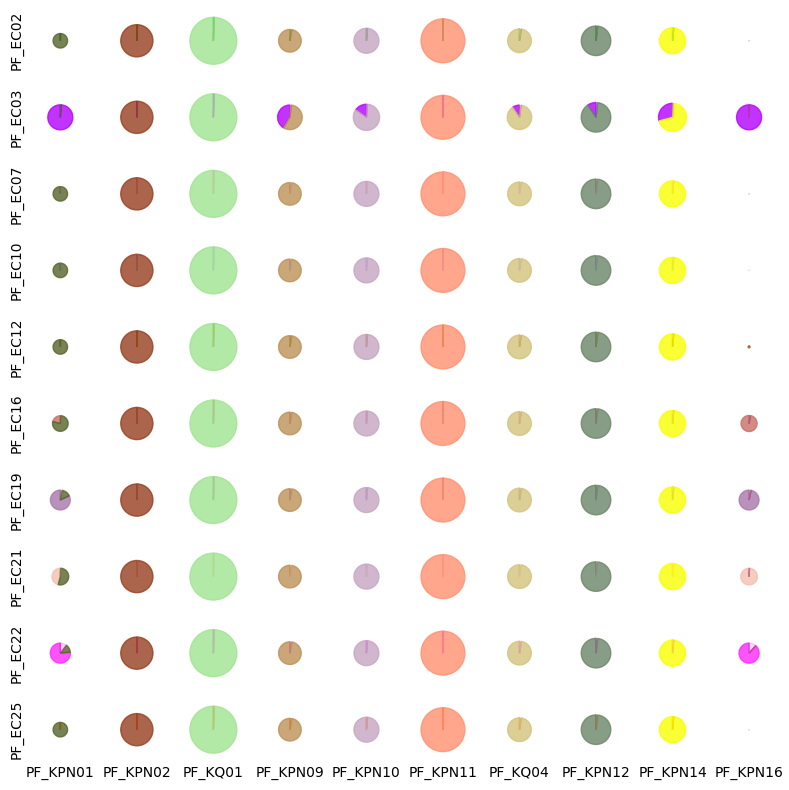

18
Exporting ./figures/N10/pairwise_strains_N10_A1638400.0e-2.pdf


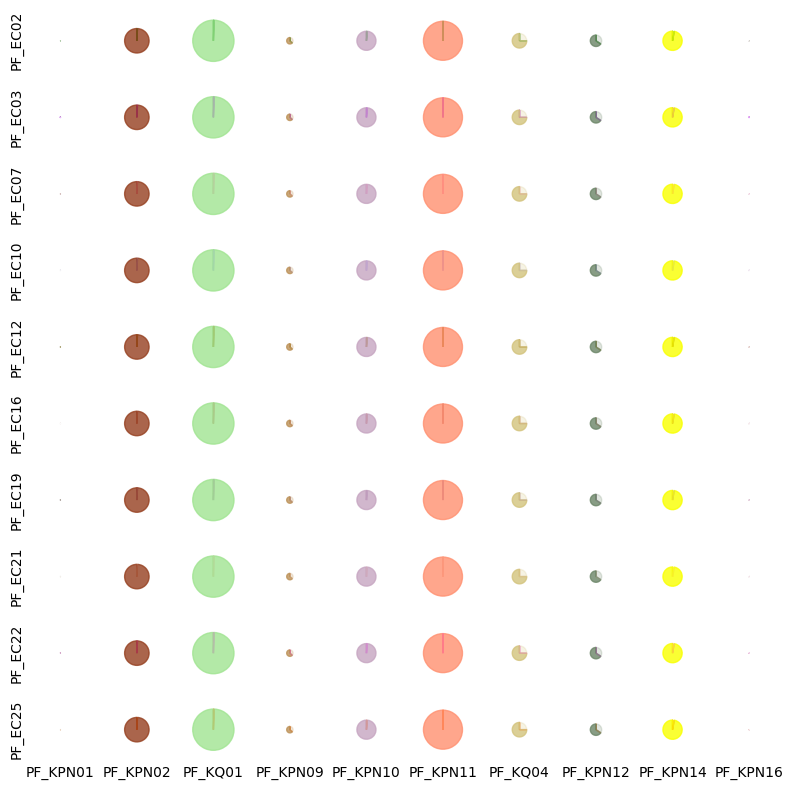

19
Exporting ./figures/N10/pairwise_strains_N10_A3276800.0e-2.pdf


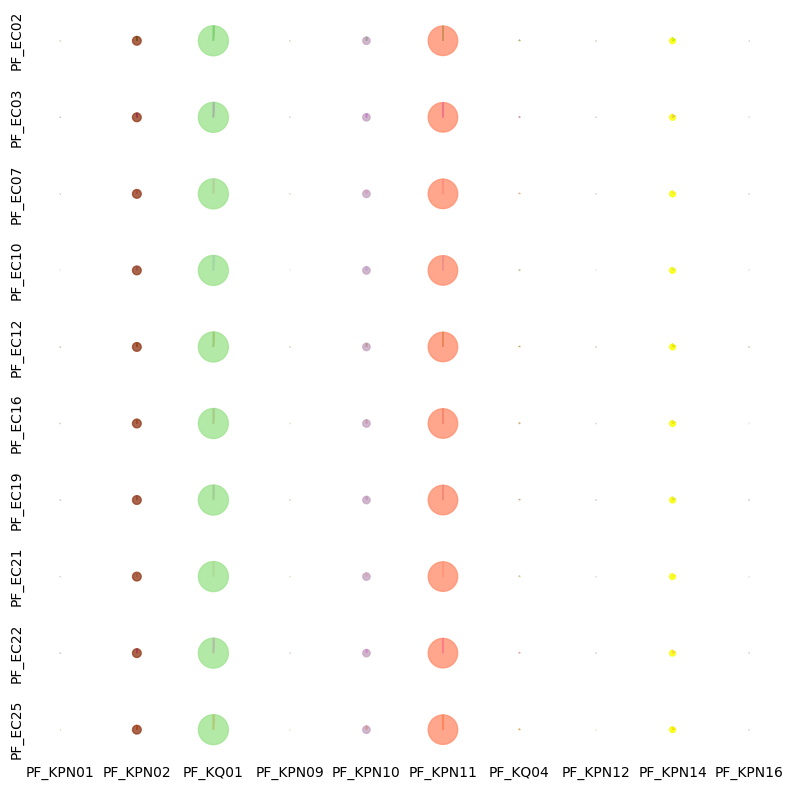

20
Exporting ./figures/N10/pairwise_strains_N10_A6553600.0e-2.pdf


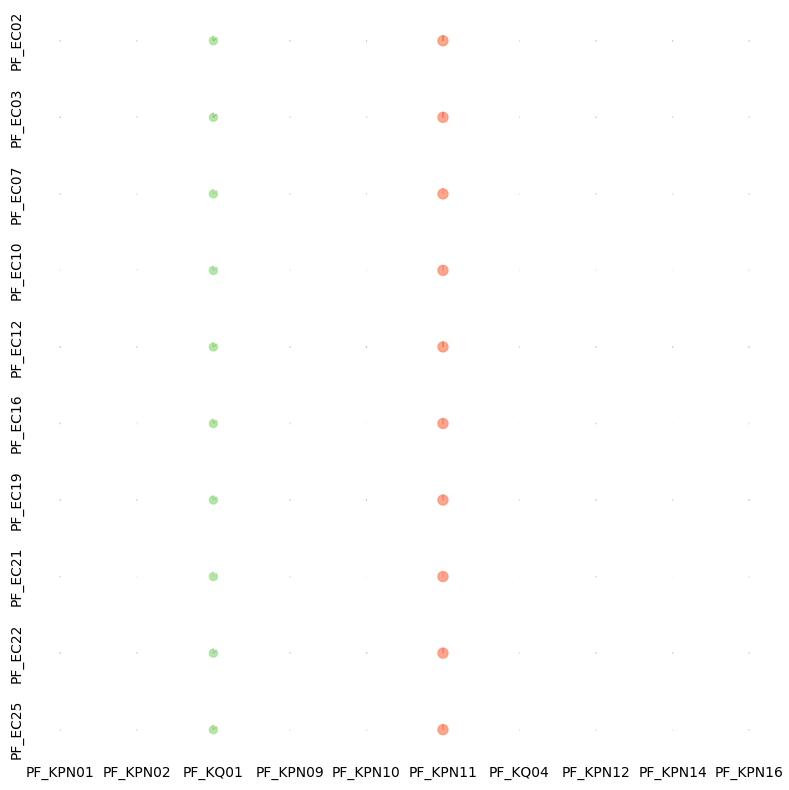

21
Exporting ./figures/N10/pairwise_strains_N10_A13107200.0e-2.pdf


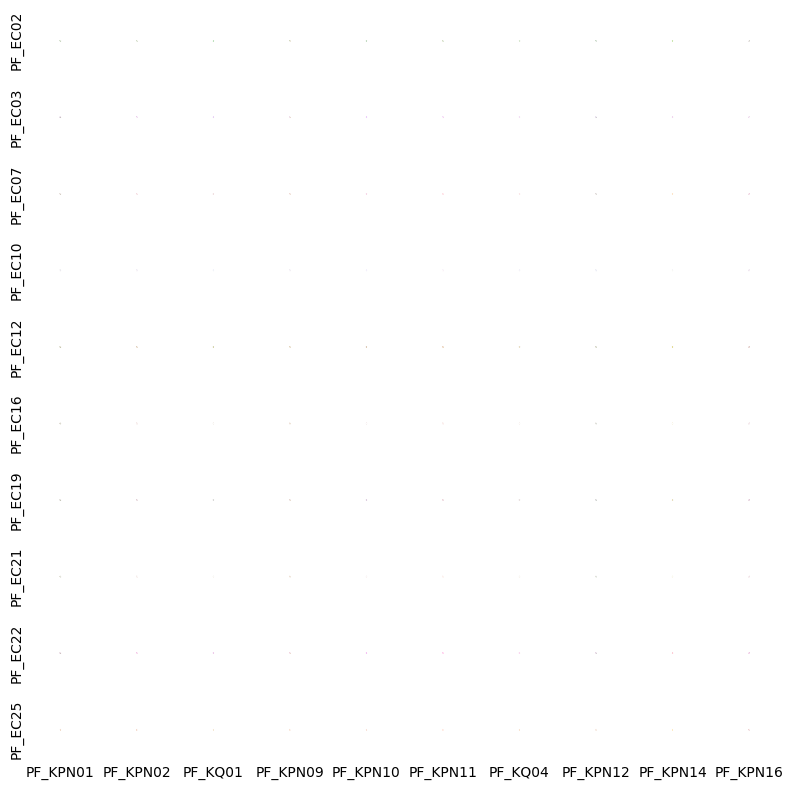

22
Exporting ./figures/N10/pairwise_strains_N10_A26214400.0e-2.pdf


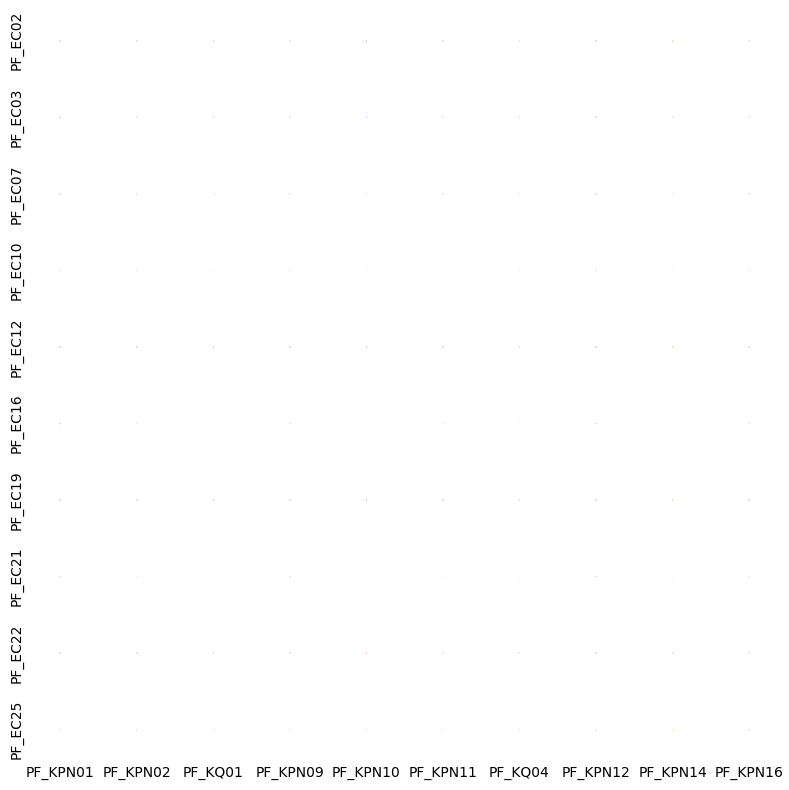

23
Exporting ./figures/N10/pairwise_strains_N10_A52428800.0e-2.pdf


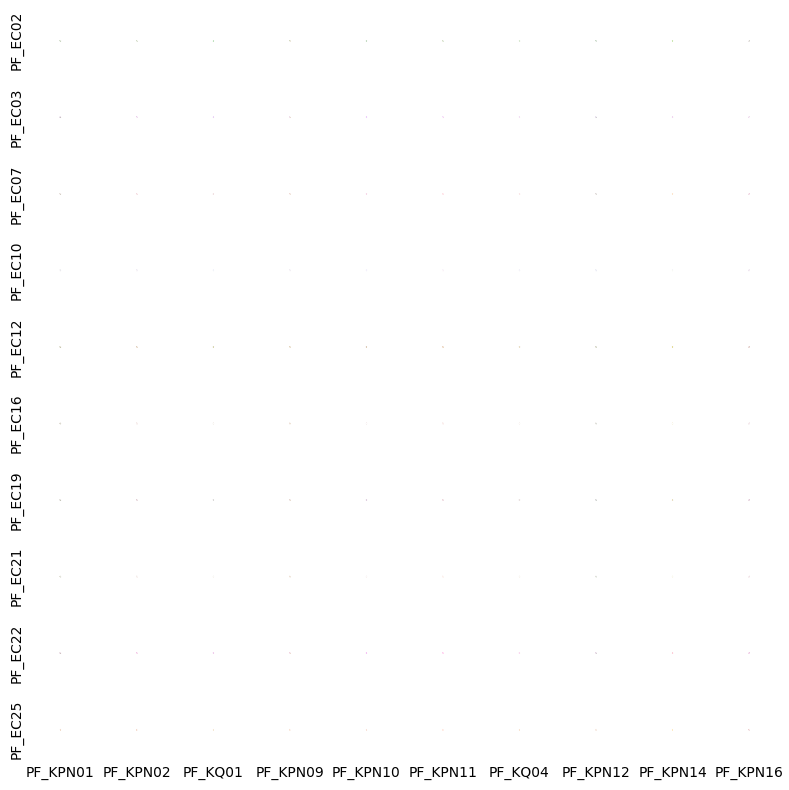

24
Exporting ./figures/N10/pairwise_strains_N10_A104857600.0e-2.pdf


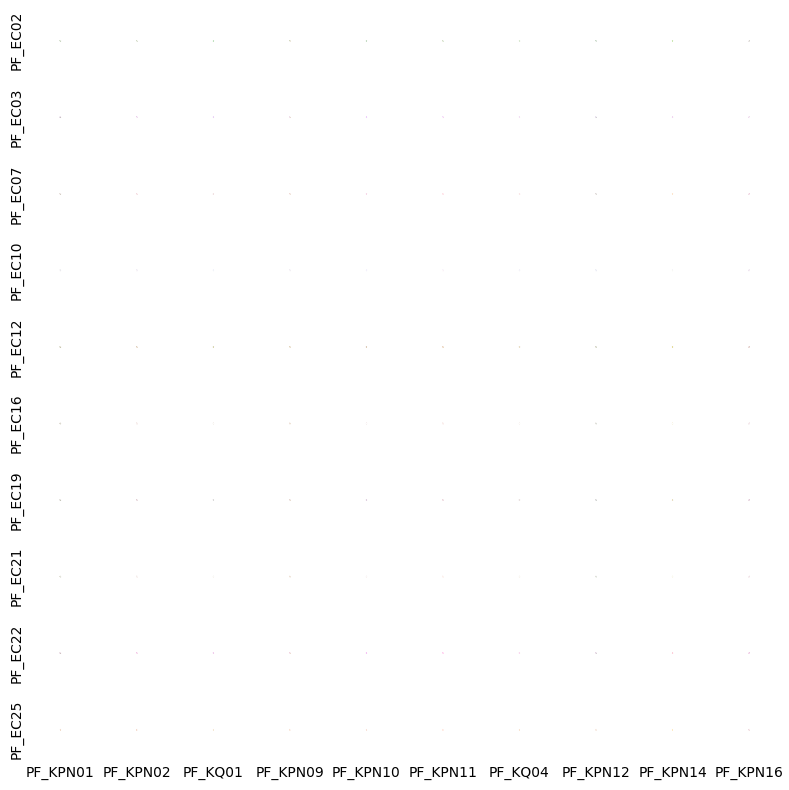

25
Exporting ./figures/N10/pairwise_strains_N10_A209715200.0e-2.pdf


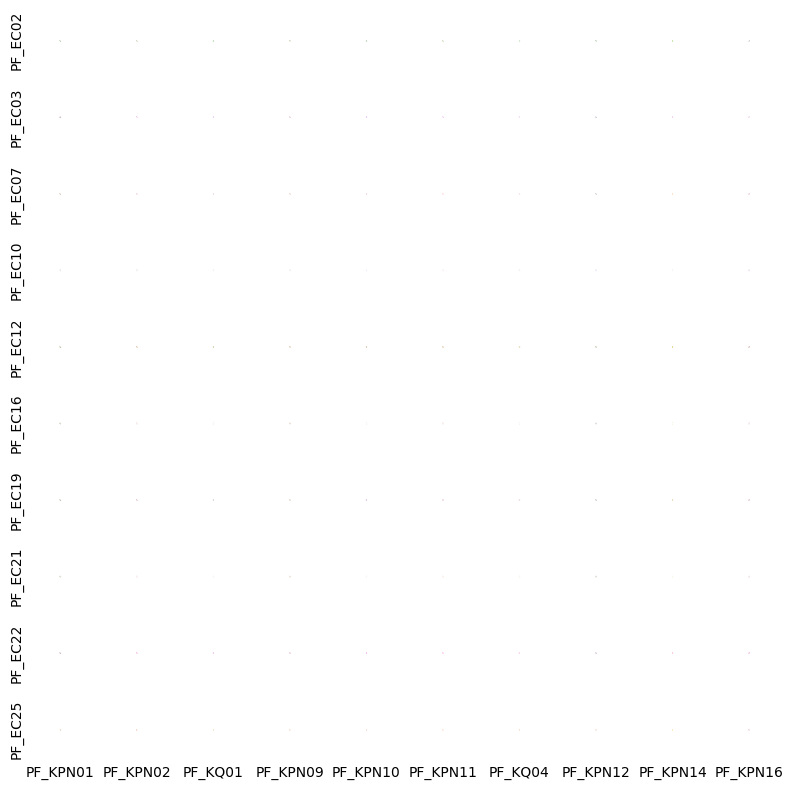

In [11]:
#max_density=1e9

for iA, results_A in sim_df.items():
    print(iA)

    fig, axs = plt.subplots(len(strains_subsetE), len(strains_subsetK), figsize=(8,8), sharey=True, sharex=True)

    for results_inner in results_A:  # These are the lists inside results_A
        for result in results_inner:  # These are the individual tuples
            final_densities, strain1, strain2 = result

            i = strains_subsetE.index(strain1)
            j = strains_subsetK.index(strain2)
            ax = axs[i, j]

            color_strains=[cmap_strains[strain1], cmap_strains[strain2], cmap_strains[strain1], cmap_strains[strain2]]
            alphas_strains=[0.8, 0.8, 0.2, 0.2]
            if np.sum(final_densities)>expe_params['extinction_threshold']:
                plot_popStructure_strains(final_densities, max_density, color_strains, alphas_strains, ax)
            else:
                ax.axis('off')

            if i==len(strains_subsetK)-1:
                ax.set_xlabel(strain_namesK[j])
            if j==0:
                ax.set_ylabel(strain_namesE[i])


    plt.tight_layout()

    figPathN="%sN%s/"%(figPath, num_days)
    if not os.path.exists(figPathN):
        os.makedirs(figPathN)
    strain_path="%spairwise_strains_N%s_A%se-2.pdf"%(figPathN, num_days, Amax_values[iA]*100)
    print("Exporting %s"%strain_path)
    plt.savefig(strain_path)

    plt.show()




In [12]:
def plot_popStructure_species(densities, max_density, colors, ax):
    """
    Plot population structure of bacterial species in a pie chart.

    This function takes in densities of various species, maximum density value, colors corresponding to each species,
    and an axes object. It then creates a pie chart representing the population structure of different bacterial species,
    with the pie's radius reflecting the total population size.

    Parameters:
    densities: list
        List of densities for each bacterial species.
    max_density: float
        Maximum possible density, used for scaling the pie chart.
    colors: list
        List of colors to use for each species in the pie chart.
    ax: matplotlib.axes._subplots.AxesSubplot
        Matplotlib axes object where the pie chart will be plotted.
    """
    num_subpopulations = len(densities)

    # Convert negative densities to zero
    densities = np.maximum(densities, 0)

    # Calculate relative abundances for each subpopulation
    total_density = sum(densities)
    # If total_density is not zero, compute relative_abundances
    if total_density != 0:
        relative_abundances = [density / total_density for density in densities]
    else:
        # Handle the case where total_density is zero
        # You might want to replace this with an appropriate fallback or error message
        relative_abundances = [0 for density in densities]

    print("\t%0.2f\t%0.2f\t%0.2f\t%0.2f"%(100*relative_abundances[0],100*relative_abundances[1],100*relative_abundances[2],100*relative_abundances[3]))
    # Calculate the radius based on the sum of densities
    small_constant = 1e-10

    # Compute radius
    radius = (total_density + small_constant)/(max_density + small_constant)

    #radius = total_density + small_constant
    #radius = np.log10(total_density + small_constant) / np.log10(max_density + small_constant)
    if radius>1:
      radius=1

    if radius< small_constant:
      radius= small_constant

    #alphas = [0.75 if i % 2 == 0 else 0.75 for i in range(num_subpopulations)]
    alphas=[0.8, 0.8, 0.2, 0.2]

    # Create the pie chart
    wedges, _ = ax.pie(relative_abundances, colors=colors, radius=radius, startangle=90)

    # Set alpha for each wedge
    for i, (wedge, alpha_val) in enumerate(zip(wedges, alphas)):
        wedge.set_alpha(alpha_val)

    # Set aspect ratio to be equal so that the pie is circular
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	15.90	19.40	63.92	0.79
PF_EC02 vs PF_KPN02	2.09	83.22	5.01	9.68
PF_EC02 vs PF_KQ01	1.67	75.94	4.11	18.28
PF_EC02 vs PF_KPN09	1.42	61.12	3.15	34.32
PF_EC02 vs PF_KPN10	18.21	5.52	74.09	2.19
PF_EC02 vs PF_KPN11	2.22	90.64	5.54	1.61
PF_EC02 vs PF_KQ04	1.55	27.77	3.35	67.34
PF_EC02 vs PF_KPN12	0.83	71.25	1.69	26.23
PF_EC02 vs PF_KPN14	15.55	6.50	63.04	14.91
PF_EC02 vs PF_KPN16	9.95	51.24	36.49	2.33
PF_EC03 vs PF_KPN01	95.74	0.44	3.72	0.10
PF_EC03 vs PF_KPN02	92.22	3.40	3.51	0.88
PF_EC03 vs PF_KQ01	91.71	3.36	3.50	1.44
PF_EC03 vs PF_KPN09	90.79	3.83	3.42	1.96
PF_EC03 vs PF_KPN10	95.86	0.25	3.73	0.16
PF_EC03 vs PF_KPN11	92.71	3.45	3.55	0.28
PF_EC03 vs PF_KQ04	92.38	2.38	3.47	1.76
PF_EC03 vs PF_KPN12	86.50	7.12	3.24	3.14
PF_EC03 vs PF_KPN14	95.65	0.33	3.71	0.30
PF_EC03 vs PF_KPN16	95.33	0.79	3.69	0.18
PF_EC07 vs PF_KPN01	12.32	45.39	41.14	1.15
PF_EC07 vs PF_KPN02	1.22	86.63	2.36	9.79
PF_EC07 vs PF_KQ01	0.96	79.27	1.87	17.90
PF_EC07 vs PF_KPN09	

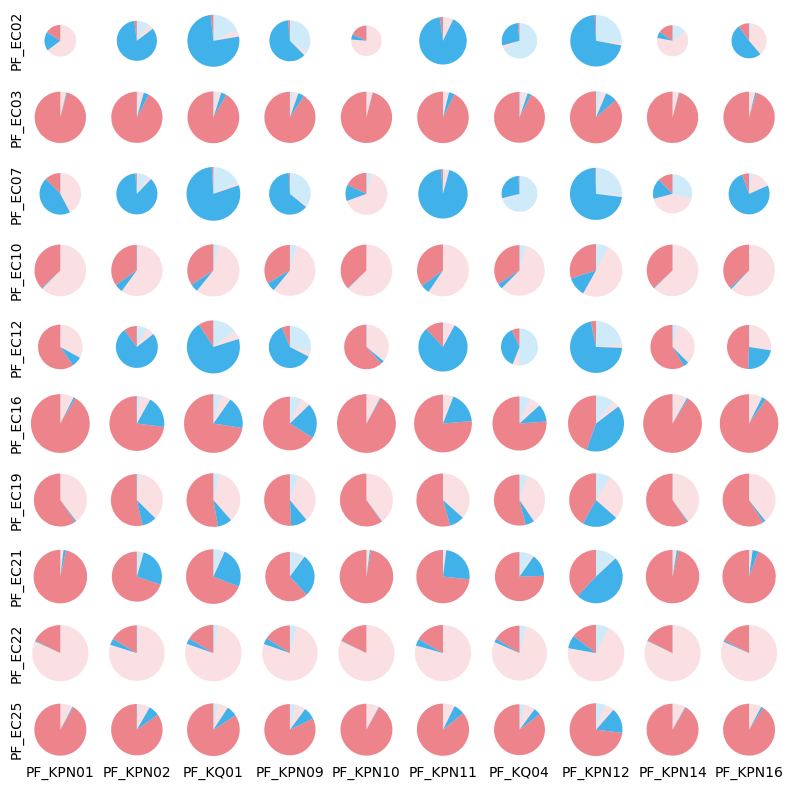

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	16.36	19.97	62.87	0.79
PF_EC02 vs PF_KPN02	2.11	83.57	4.82	9.51
PF_EC02 vs PF_KQ01	1.68	76.23	3.95	18.14
PF_EC02 vs PF_KPN09	1.43	61.43	3.03	34.12
PF_EC02 vs PF_KPN10	18.84	5.68	73.30	2.19
PF_EC02 vs PF_KPN11	2.23	90.88	5.30	1.60
PF_EC02 vs PF_KQ04	1.57	28.11	3.25	67.07
PF_EC02 vs PF_KPN12	0.84	71.45	1.62	26.09
PF_EC02 vs PF_KPN14	16.08	6.69	62.33	14.90
PF_EC02 vs PF_KPN16	10.13	52.25	35.44	2.19
PF_EC03 vs PF_KPN01	95.99	0.44	3.48	0.09
PF_EC03 vs PF_KPN02	92.47	3.39	3.28	0.86
PF_EC03 vs PF_KQ01	91.95	3.36	3.27	1.42
PF_EC03 vs PF_KPN09	91.04	3.83	3.20	1.94
PF_EC03 vs PF_KPN10	96.11	0.25	3.48	0.16
PF_EC03 vs PF_KPN11	92.94	3.46	3.32	0.28
PF_EC03 vs PF_KQ04	92.67	2.35	3.25	1.73
PF_EC03 vs PF_KPN12	86.76	7.10	3.03	3.11
PF_EC03 vs PF_KPN14	95.90	0.33	3.47	0.30
PF_EC03 vs PF_KPN16	95.59	0.79	3.45	0.17
PF_EC07 vs PF_KPN01	12.43	45.87	40.55	1.15
PF_EC07 vs PF_KPN02	1.23	86.84	2.32	9.62
PF_EC07 vs PF_KQ01	0.96	79.41	1.84	17.79
PF_EC07 vs PF_KPN09

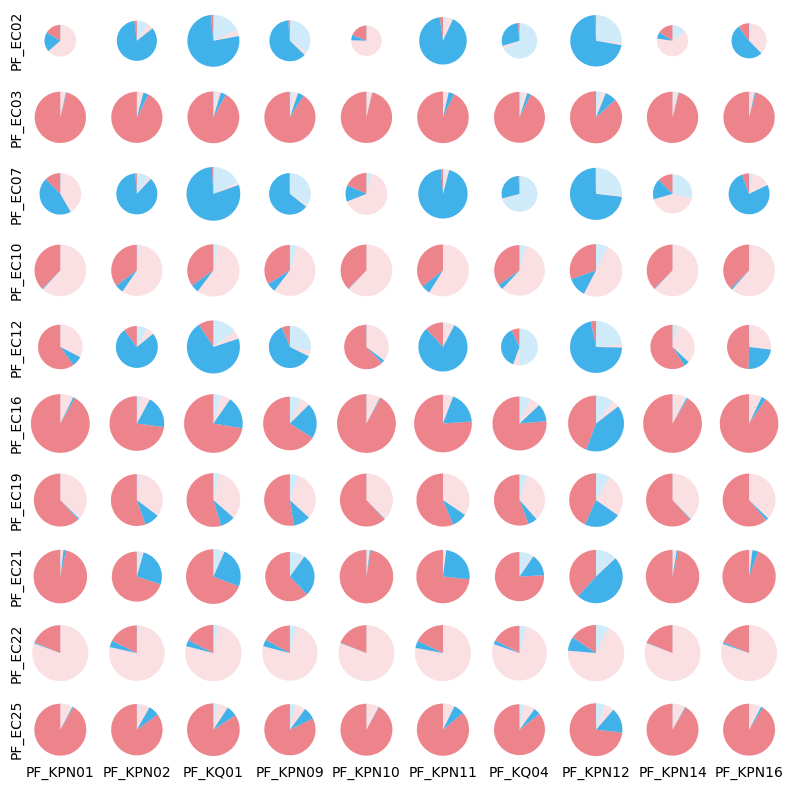

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	17.29	21.15	60.75	0.81
PF_EC02 vs PF_KPN02	2.15	84.23	4.45	9.18
PF_EC02 vs PF_KQ01	1.71	76.79	3.65	17.85
PF_EC02 vs PF_KPN09	1.45	62.03	2.80	33.72
PF_EC02 vs PF_KPN10	20.13	6.01	71.67	2.19
PF_EC02 vs PF_KPN11	2.24	91.33	4.85	1.58
PF_EC02 vs PF_KQ04	1.63	28.78	3.07	66.52
PF_EC02 vs PF_KPN12	0.85	71.84	1.50	25.82
PF_EC02 vs PF_KPN14	17.17	7.08	60.89	14.86
PF_EC02 vs PF_KPN16	10.49	54.21	33.36	1.94
PF_EC03 vs PF_KPN01	96.42	0.45	3.04	0.09
PF_EC03 vs PF_KPN02	92.91	3.38	2.88	0.82
PF_EC03 vs PF_KQ01	92.39	3.35	2.87	1.39
PF_EC03 vs PF_KPN09	91.48	3.81	2.81	1.90
PF_EC03 vs PF_KPN10	96.55	0.25	3.05	0.15
PF_EC03 vs PF_KPN11	93.33	3.48	2.91	0.28
PF_EC03 vs PF_KQ04	93.19	2.30	2.85	1.65
PF_EC03 vs PF_KPN12	87.22	7.06	2.66	3.05
PF_EC03 vs PF_KPN14	96.35	0.33	3.03	0.28
PF_EC03 vs PF_KPN16	96.04	0.80	3.02	0.14
PF_EC07 vs PF_KPN01	12.66	46.82	39.37	1.15
PF_EC07 vs PF_KPN02	1.24	87.24	2.24	9.28
PF_EC07 vs PF_KQ01	0.97	79.70	1.78	17.56
PF_EC07 vs PF_KPN09

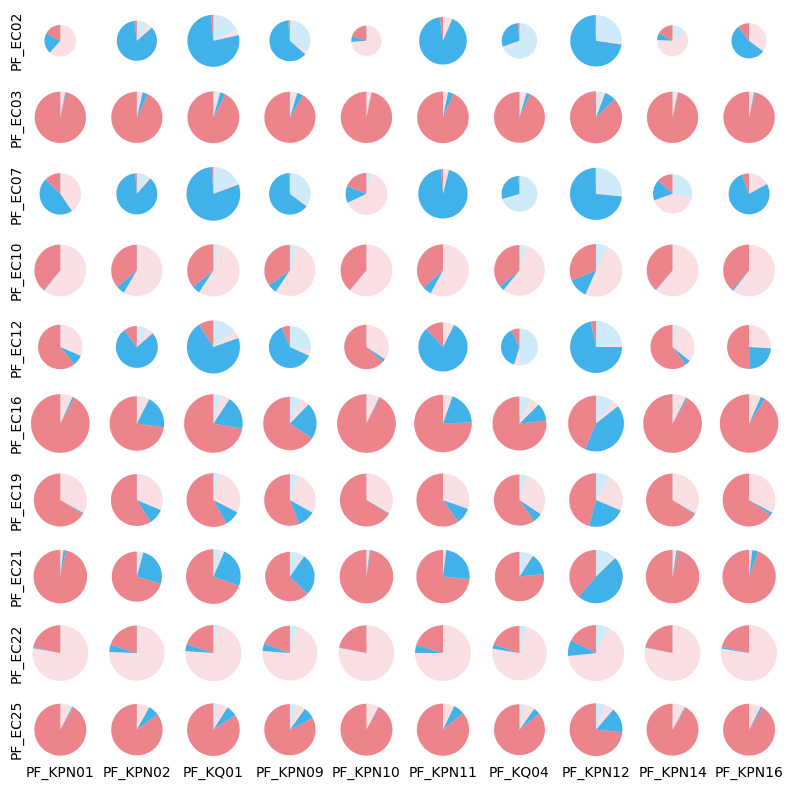

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	19.21	23.57	56.39	0.83
PF_EC02 vs PF_KPN02	2.22	85.45	3.79	8.54
PF_EC02 vs PF_KQ01	1.77	77.82	3.11	17.30
PF_EC02 vs PF_KPN09	1.50	63.16	2.39	32.94
PF_EC02 vs PF_KPN10	22.90	6.70	68.22	2.18
PF_EC02 vs PF_KPN11	2.28	92.12	4.05	1.55
PF_EC02 vs PF_KQ04	1.74	30.13	2.73	65.40
PF_EC02 vs PF_KPN12	0.87	72.58	1.27	25.27
PF_EC02 vs PF_KPN14	19.52	7.88	57.91	14.70
PF_EC02 vs PF_KPN16	11.17	57.92	29.35	1.55
PF_EC03 vs PF_KPN01	97.09	0.45	2.37	0.09
PF_EC03 vs PF_KPN02	93.63	3.35	2.26	0.76
PF_EC03 vs PF_KQ01	93.09	3.32	2.24	1.34
PF_EC03 vs PF_KPN09	92.20	3.77	2.20	1.82
PF_EC03 vs PF_KPN10	97.23	0.25	2.38	0.14
PF_EC03 vs PF_KPN11	93.96	3.50	2.28	0.27
PF_EC03 vs PF_KQ04	94.05	2.19	2.24	1.52
PF_EC03 vs PF_KPN12	88.01	6.96	2.09	2.93
PF_EC03 vs PF_KPN14	97.05	0.32	2.37	0.26
PF_EC03 vs PF_KPN16	96.73	0.80	2.36	0.10
PF_EC07 vs PF_KPN01	13.11	48.70	37.05	1.14
PF_EC07 vs PF_KPN02	1.27	88.00	2.09	8.64
PF_EC07 vs PF_KQ01	1.00	80.25	1.66	17.10
PF_EC07 vs PF_KPN09

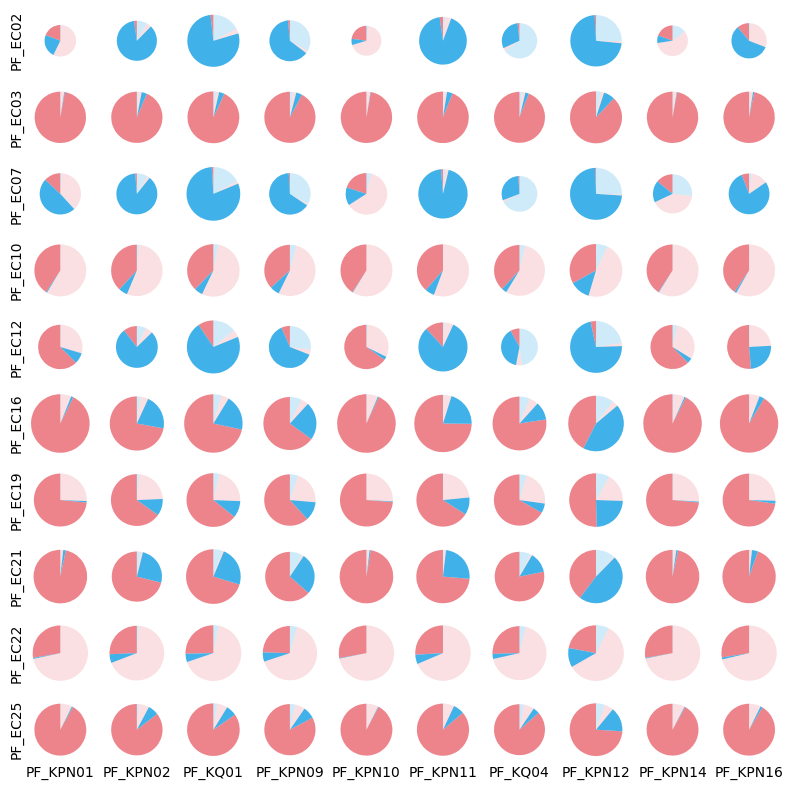

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	23.14	28.57	47.42	0.86
PF_EC02 vs PF_KPN02	2.34	87.53	2.74	7.39
PF_EC02 vs PF_KQ01	1.87	79.59	2.26	16.28
PF_EC02 vs PF_KPN09	1.60	65.22	1.74	31.44
PF_EC02 vs PF_KPN10	29.05	8.18	60.64	2.14
PF_EC02 vs PF_KPN11	2.34	93.35	2.82	1.49
PF_EC02 vs PF_KQ04	1.99	32.79	2.16	63.05
PF_EC02 vs PF_KPN12	0.92	73.93	0.92	24.22
PF_EC02 vs PF_KPN14	24.82	9.49	51.60	14.09
PF_EC02 vs PF_KPN16	12.36	64.37	22.17	1.10
PF_EC03 vs PF_KPN01	97.89	0.46	1.57	0.08
PF_EC03 vs PF_KPN02	94.57	3.28	1.51	0.64
PF_EC03 vs PF_KQ01	94.02	3.24	1.50	1.23
PF_EC03 vs PF_KPN09	93.19	3.66	1.48	1.68
PF_EC03 vs PF_KPN10	98.05	0.26	1.58	0.12
PF_EC03 vs PF_KPN11	94.72	3.51	1.52	0.26
PF_EC03 vs PF_KQ04	95.24	1.97	1.51	1.28
PF_EC03 vs PF_KPN12	89.17	6.71	1.41	2.70
PF_EC03 vs PF_KPN14	97.90	0.31	1.57	0.22
PF_EC03 vs PF_KPN16	97.57	0.80	1.57	0.06
PF_EC07 vs PF_KPN01	13.97	52.30	32.60	1.13
PF_EC07 vs PF_KPN02	1.33	89.40	1.80	7.47
PF_EC07 vs PF_KQ01	1.04	81.32	1.44	16.20
PF_EC07 vs PF_KPN09

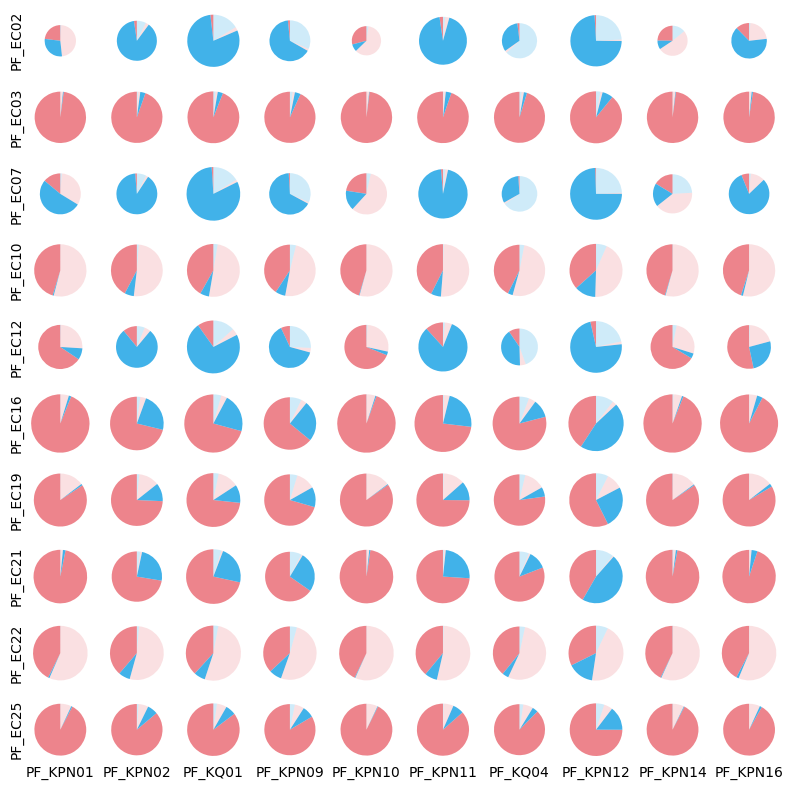

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	30.51	38.06	30.53	0.90
PF_EC02 vs PF_KPN02	2.55	90.55	1.40	5.49
PF_EC02 vs PF_KQ01	2.08	82.30	1.18	14.44
PF_EC02 vs PF_KPN09	1.79	68.68	0.92	28.61
PF_EC02 vs PF_KPN10	42.73	11.28	44.06	1.93
PF_EC02 vs PF_KPN11	2.42	94.84	1.36	1.38
PF_EC02 vs PF_KQ04	2.60	37.99	1.37	58.05
PF_EC02 vs PF_KPN12	1.02	76.25	0.49	22.24
PF_EC02 vs PF_KPN14	37.31	12.38	38.30	12.01
PF_EC02 vs PF_KPN16	14.09	73.27	11.85	0.79
PF_EC03 vs PF_KPN01	98.48	0.46	0.99	0.07
PF_EC03 vs PF_KPN02	95.46	3.12	0.96	0.46
PF_EC03 vs PF_KQ01	94.95	3.05	0.96	1.04
PF_EC03 vs PF_KPN09	94.24	3.39	0.95	1.42
PF_EC03 vs PF_KPN10	98.66	0.26	0.99	0.09
PF_EC03 vs PF_KPN11	95.33	3.47	0.96	0.24
PF_EC03 vs PF_KQ04	96.55	1.57	0.97	0.90
PF_EC03 vs PF_KPN12	90.64	6.16	0.91	2.29
PF_EC03 vs PF_KPN14	98.57	0.29	0.99	0.16
PF_EC03 vs PF_KPN16	98.20	0.80	0.99	0.02
PF_EC07 vs PF_KPN01	15.49	58.77	24.64	1.09
PF_EC07 vs PF_KPN02	1.43	91.69	1.33	5.55
PF_EC07 vs PF_KQ01	1.14	83.30	1.08	14.48
PF_EC07 vs PF_KPN

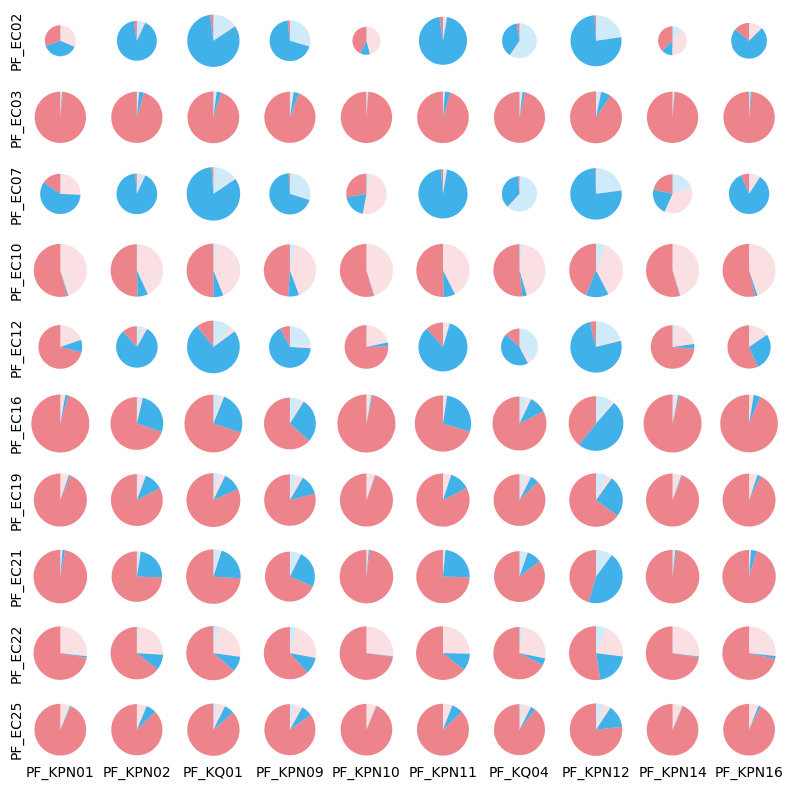

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	39.30	49.64	10.22	0.84
PF_EC02 vs PF_KPN02	2.82	93.74	0.37	3.07
PF_EC02 vs PF_KQ01	2.48	85.86	0.34	11.32
PF_EC02 vs PF_KPN09	2.18	74.10	0.28	23.44
PF_EC02 vs PF_KPN10	64.94	15.92	17.86	1.28
PF_EC02 vs PF_KPN11	2.52	95.94	0.34	1.19
PF_EC02 vs PF_KQ04	4.36	47.73	0.60	47.31
PF_EC02 vs PF_KPN12	1.23	80.05	0.14	18.58
PF_EC02 vs PF_KPN14	61.37	14.76	16.81	7.07
PF_EC02 vs PF_KPN16	15.80	80.21	3.26	0.73
PF_EC03 vs PF_KPN01	98.68	0.46	0.80	0.05
PF_EC03 vs PF_KPN02	96.08	2.90	0.79	0.23
PF_EC03 vs PF_KQ01	95.79	2.69	0.78	0.74
PF_EC03 vs PF_KPN09	95.30	2.91	0.78	1.00
PF_EC03 vs PF_KPN10	98.89	0.26	0.80	0.05
PF_EC03 vs PF_KPN11	95.66	3.35	0.78	0.21
PF_EC03 vs PF_KQ04	97.69	1.06	0.80	0.45
PF_EC03 vs PF_KPN12	92.43	5.18	0.76	1.63
PF_EC03 vs PF_KPN14	98.86	0.25	0.80	0.08
PF_EC03 vs PF_KPN16	98.43	0.77	0.80	0.01
PF_EC07 vs PF_KPN01	17.66	68.18	13.17	1.00
PF_EC07 vs PF_KPN02	1.56	94.66	0.69	3.10
PF_EC07 vs PF_KQ01	1.32	86.68	0.60	11.40
PF_EC07 vs PF_KPN09

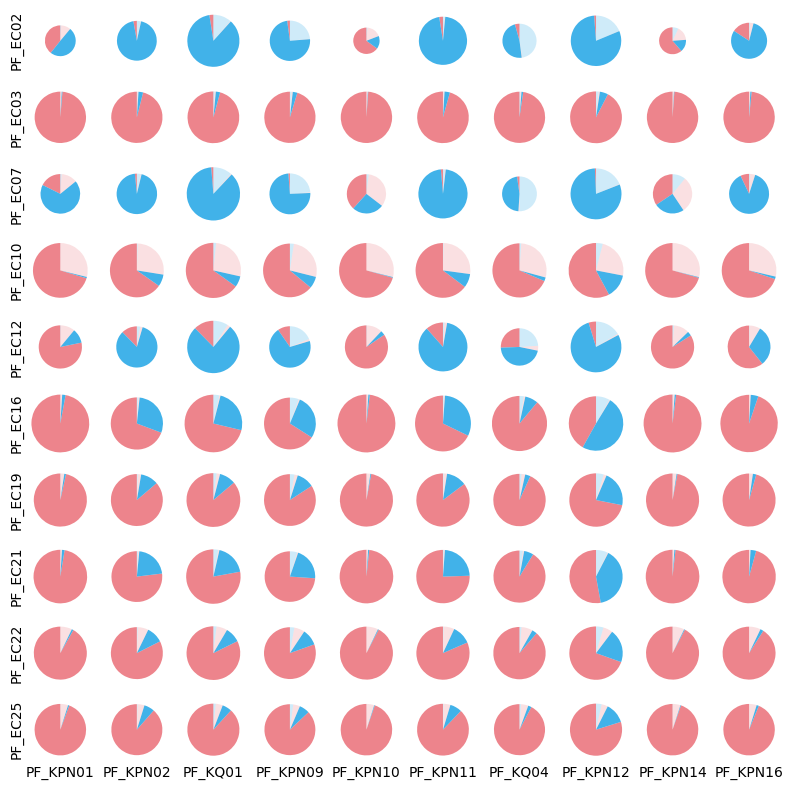

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	42.47	54.15	2.76	0.63
PF_EC02 vs PF_KPN02	3.00	95.69	0.07	1.24
PF_EC02 vs PF_KQ01	3.19	90.05	0.09	6.68
PF_EC02 vs PF_KPN09	3.01	82.06	0.07	14.86
PF_EC02 vs PF_KPN10	75.88	18.22	5.40	0.51
PF_EC02 vs PF_KPN11	2.65	96.39	0.06	0.90
PF_EC02 vs PF_KQ04	11.06	62.15	0.41	26.38
PF_EC02 vs PF_KPN12	1.68	86.02	0.03	12.26
PF_EC02 vs PF_KPN14	79.16	13.37	5.62	1.85
PF_EC02 vs PF_KPN16	17.20	81.27	0.81	0.72
PF_EC03 vs PF_KPN01	98.74	0.46	0.76	0.03
PF_EC03 vs PF_KPN02	96.44	2.74	0.75	0.07
PF_EC03 vs PF_KQ01	96.62	2.25	0.75	0.37
PF_EC03 vs PF_KPN09	96.43	2.31	0.75	0.50
PF_EC03 vs PF_KPN10	98.96	0.26	0.76	0.01
PF_EC03 vs PF_KPN11	95.95	3.15	0.75	0.15
PF_EC03 vs PF_KQ04	98.44	0.68	0.76	0.11
PF_EC03 vs PF_KPN12	94.52	3.92	0.74	0.82
PF_EC03 vs PF_KPN14	98.98	0.23	0.76	0.02
PF_EC03 vs PF_KPN16	98.53	0.71	0.76	0.00
PF_EC07 vs PF_KPN01	19.39	76.17	3.62	0.81
PF_EC07 vs PF_KPN02	1.65	96.92	0.18	1.25
PF_EC07 vs PF_KQ01	1.67	91.46	0.19	6.69
PF_EC07 vs PF_KPN09	1.64

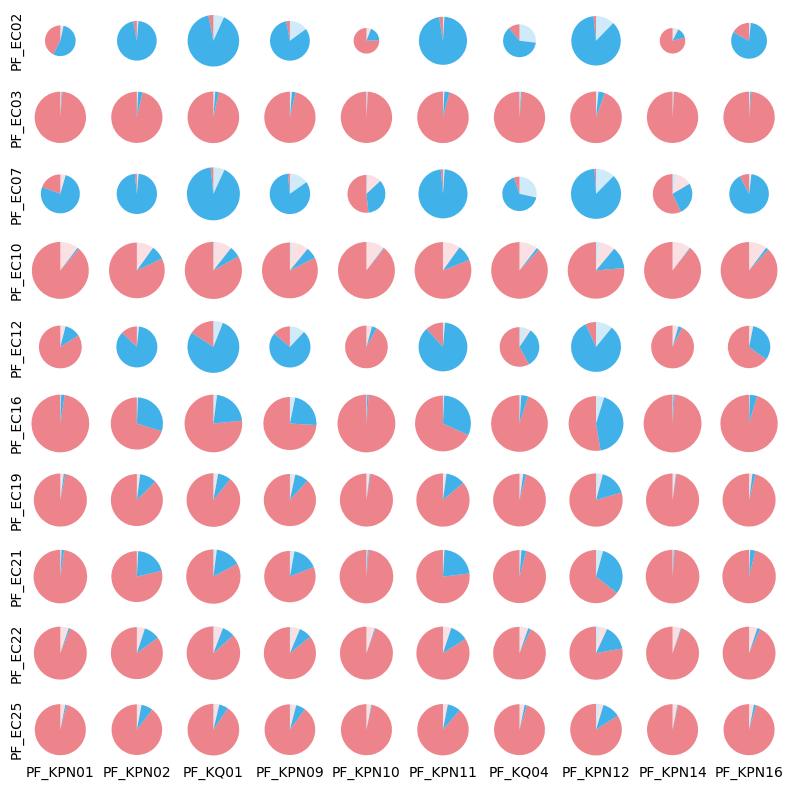

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	42.50	54.92	2.12	0.46
PF_EC02 vs PF_KPN02	3.01	96.22	0.05	0.72
PF_EC02 vs PF_KQ01	4.00	93.69	0.08	2.23
PF_EC02 vs PF_KPN09	4.28	90.56	0.08	5.07
PF_EC02 vs PF_KPN10	76.75	18.75	4.23	0.27
PF_EC02 vs PF_KPN11	2.77	96.65	0.04	0.54
PF_EC02 vs PF_KQ04	26.35	67.46	1.08	5.12
PF_EC02 vs PF_KPN12	2.43	93.13	0.04	4.41
PF_EC02 vs PF_KPN14	82.44	12.67	4.54	0.35
PF_EC02 vs PF_KPN16	19.48	79.14	0.70	0.68
PF_EC03 vs PF_KPN01	98.79	0.46	0.73	0.01
PF_EC03 vs PF_KPN02	96.54	2.72	0.72	0.02
PF_EC03 vs PF_KQ01	97.23	1.94	0.73	0.10
PF_EC03 vs PF_KPN09	97.27	1.87	0.73	0.13
PF_EC03 vs PF_KPN10	99.00	0.26	0.73	0.00
PF_EC03 vs PF_KPN11	96.28	2.91	0.72	0.08
PF_EC03 vs PF_KQ04	98.69	0.57	0.73	0.01
PF_EC03 vs PF_KPN12	96.09	2.97	0.72	0.22
PF_EC03 vs PF_KPN14	99.04	0.22	0.73	0.00
PF_EC03 vs PF_KPN16	98.67	0.60	0.73	0.00
PF_EC07 vs PF_KPN01	19.71	78.70	0.94	0.65
PF_EC07 vs PF_KPN02	1.66	97.59	0.03	0.72
PF_EC07 vs PF_KQ01	2.05	95.70	0.04	2.21
PF_EC07 vs PF_KPN09	2.24	92

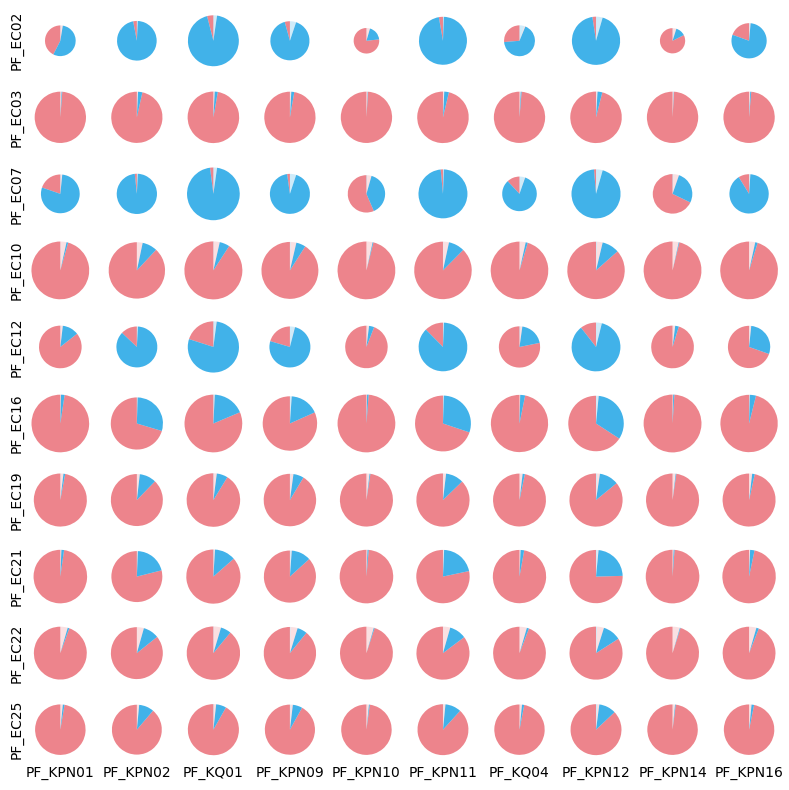

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	42.03	55.74	1.82	0.41
PF_EC02 vs PF_KPN02	2.90	96.40	0.04	0.67
PF_EC02 vs PF_KQ01	4.15	95.00	0.07	0.78
PF_EC02 vs PF_KPN09	4.79	93.81	0.08	1.33
PF_EC02 vs PF_KPN10	76.63	19.43	3.68	0.25
PF_EC02 vs PF_KPN11	2.79	96.91	0.04	0.26
PF_EC02 vs PF_KQ04	28.45	68.07	1.05	2.43
PF_EC02 vs PF_KPN12	2.77	96.13	0.04	1.06
PF_EC02 vs PF_KPN14	82.73	13.07	3.96	0.25
PF_EC02 vs PF_KPN16	24.68	73.89	0.81	0.62
PF_EC03 vs PF_KPN01	98.83	0.46	0.70	0.00
PF_EC03 vs PF_KPN02	96.52	2.77	0.70	0.01
PF_EC03 vs PF_KQ01	97.40	1.89	0.70	0.02
PF_EC03 vs PF_KPN09	97.53	1.75	0.70	0.02
PF_EC03 vs PF_KPN10	99.03	0.27	0.70	0.00
PF_EC03 vs PF_KPN11	96.50	2.77	0.69	0.03
PF_EC03 vs PF_KQ04	98.72	0.57	0.70	0.00
PF_EC03 vs PF_KPN12	96.57	2.71	0.69	0.03
PF_EC03 vs PF_KPN14	99.07	0.22	0.70	0.00
PF_EC03 vs PF_KPN16	98.87	0.43	0.70	0.00
PF_EC07 vs PF_KPN01	19.32	79.36	0.72	0.60
PF_EC07 vs PF_KPN02	1.59	97.72	0.02	0.66
PF_EC07 vs PF_KQ01	2.11	97.09	0.03	0.76
PF_EC07 vs PF_KPN09	2.47	96

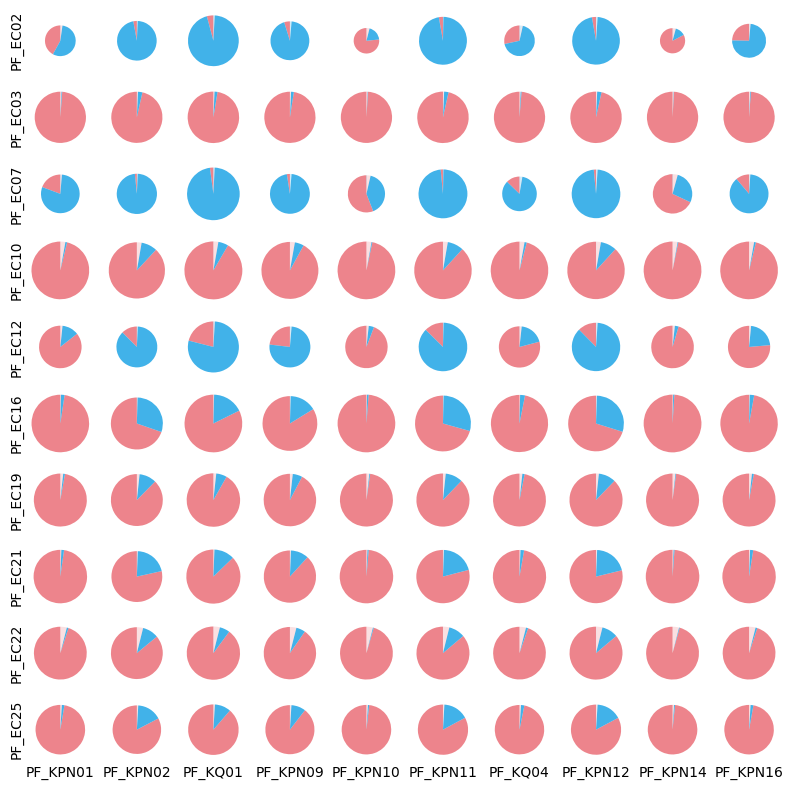

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	40.89	57.15	1.56	0.41
PF_EC02 vs PF_KPN02	2.69	96.65	0.03	0.63
PF_EC02 vs PF_KQ01	3.84	95.44	0.05	0.66
PF_EC02 vs PF_KPN09	4.57	94.32	0.06	1.05
PF_EC02 vs PF_KPN10	75.79	20.74	3.22	0.25
PF_EC02 vs PF_KPN11	2.60	97.19	0.03	0.18
PF_EC02 vs PF_KQ04	27.40	69.70	0.89	2.00
PF_EC02 vs PF_KPN12	2.64	96.52	0.03	0.81
PF_EC02 vs PF_KPN14	82.36	13.93	3.48	0.23
PF_EC02 vs PF_KPN16	37.66	60.65	1.18	0.51
PF_EC03 vs PF_KPN01	98.85	0.46	0.68	0.00
PF_EC03 vs PF_KPN02	96.43	2.88	0.67	0.01
PF_EC03 vs PF_KQ01	97.34	1.98	0.68	0.01
PF_EC03 vs PF_KPN09	97.55	1.76	0.68	0.01
PF_EC03 vs PF_KPN10	99.04	0.27	0.68	0.00
PF_EC03 vs PF_KPN11	96.48	2.84	0.67	0.01
PF_EC03 vs PF_KQ04	98.73	0.58	0.68	0.00
PF_EC03 vs PF_KPN12	96.58	2.74	0.67	0.01
PF_EC03 vs PF_KPN14	99.09	0.23	0.68	0.00
PF_EC03 vs PF_KPN16	99.10	0.22	0.68	0.00
PF_EC07 vs PF_KPN01	18.49	80.33	0.59	0.59
PF_EC07 vs PF_KPN02	1.47	97.88	0.01	0.63
PF_EC07 vs PF_KQ01	1.95	97.38	0.02	0.65
PF_EC07 vs PF_KPN09	2.34	96

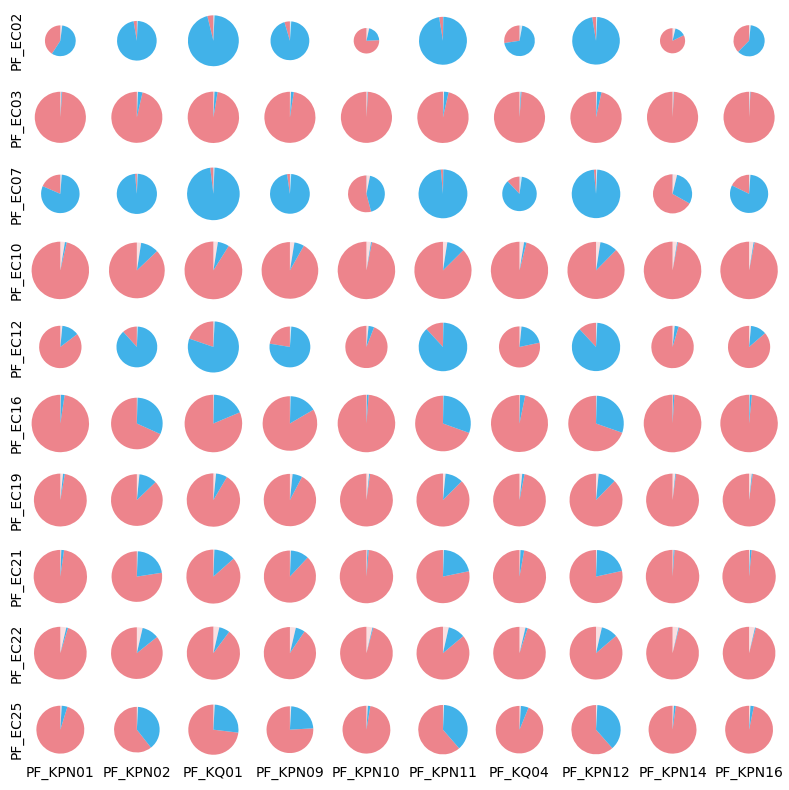

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	38.49	59.75	1.34	0.42
PF_EC02 vs PF_KPN02	2.30	97.08	0.02	0.60
PF_EC02 vs PF_KQ01	3.25	96.09	0.04	0.62
PF_EC02 vs PF_KPN09	4.08	94.91	0.05	0.96
PF_EC02 vs PF_KPN10	73.42	23.46	2.85	0.27
PF_EC02 vs PF_KPN11	2.20	97.61	0.02	0.17
PF_EC02 vs PF_KQ04	24.76	72.79	0.73	1.72
PF_EC02 vs PF_KPN12	2.34	96.89	0.02	0.74
PF_EC02 vs PF_KPN14	80.87	15.78	3.12	0.23
PF_EC02 vs PF_KPN16	67.58	29.92	2.24	0.25
PF_EC03 vs PF_KPN01	98.86	0.46	0.67	0.00
PF_EC03 vs PF_KPN02	96.20	3.13	0.66	0.01
PF_EC03 vs PF_KQ01	97.15	2.18	0.66	0.01
PF_EC03 vs PF_KPN09	97.51	1.81	0.67	0.01
PF_EC03 vs PF_KPN10	99.04	0.29	0.67	0.00
PF_EC03 vs PF_KPN11	96.19	3.14	0.66	0.00
PF_EC03 vs PF_KQ04	98.71	0.61	0.67	0.00
PF_EC03 vs PF_KPN12	96.49	2.84	0.66	0.01
PF_EC03 vs PF_KPN14	99.09	0.24	0.67	0.00
PF_EC03 vs PF_KPN16	99.27	0.06	0.67	0.00
PF_EC07 vs PF_KPN01	16.87	82.07	0.48	0.59
PF_EC07 vs PF_KPN02	1.25	98.14	0.01	0.60
PF_EC07 vs PF_KQ01	1.64	97.74	0.02	0.60
PF_EC07 vs PF_KPN09	2.07	96

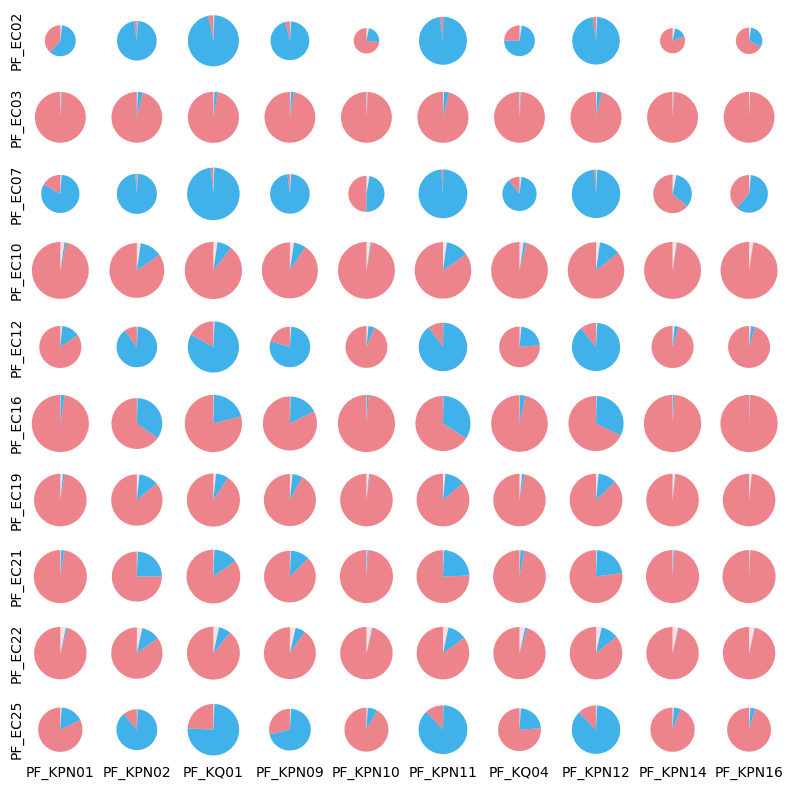

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	33.77	64.71	1.08	0.44
PF_EC02 vs PF_KPN02	1.68	97.73	0.01	0.58
PF_EC02 vs PF_KQ01	2.30	97.09	0.03	0.58
PF_EC02 vs PF_KPN09	3.23	95.84	0.04	0.89
PF_EC02 vs PF_KPN10	67.67	29.54	2.47	0.32
PF_EC02 vs PF_KPN11	1.55	98.27	0.01	0.16
PF_EC02 vs PF_KQ04	19.58	78.31	0.52	1.59
PF_EC02 vs PF_KPN12	1.83	97.46	0.02	0.69
PF_EC02 vs PF_KPN14	76.90	20.06	2.77	0.27
PF_EC02 vs PF_KPN16	94.23	2.61	3.14	0.02
PF_EC03 vs PF_KPN01	98.87	0.46	0.66	0.00
PF_EC03 vs PF_KPN02	95.65	3.69	0.65	0.01
PF_EC03 vs PF_KQ01	96.69	2.65	0.65	0.01
PF_EC03 vs PF_KPN09	97.42	1.92	0.66	0.01
PF_EC03 vs PF_KPN10	99.01	0.33	0.66	0.00
PF_EC03 vs PF_KPN11	95.48	3.87	0.65	0.01
PF_EC03 vs PF_KQ04	98.66	0.68	0.66	0.00
PF_EC03 vs PF_KPN12	96.29	3.05	0.65	0.01
PF_EC03 vs PF_KPN14	99.07	0.27	0.66	0.00
PF_EC03 vs PF_KPN16	99.33	0.01	0.66	0.00
PF_EC07 vs PF_KPN01	13.94	85.11	0.36	0.59
PF_EC07 vs PF_KPN02	0.91	98.51	0.01	0.58
PF_EC07 vs PF_KQ01	1.15	98.28	0.01	0.57
PF_EC07 vs PF_KPN09	1.61	97.

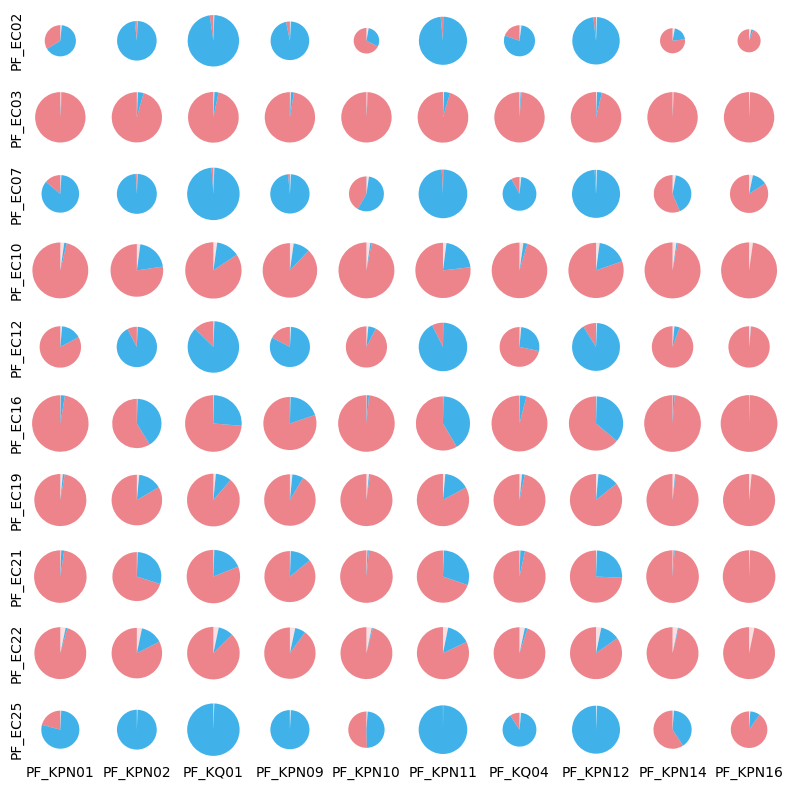

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	25.16	73.61	0.74	0.49
PF_EC02 vs PF_KPN02	0.89	98.54	0.01	0.57
PF_EC02 vs PF_KQ01	1.14	98.30	0.01	0.55
PF_EC02 vs PF_KPN09	2.00	97.13	0.02	0.86
PF_EC02 vs PF_KPN10	53.62	44.00	1.89	0.48
PF_EC02 vs PF_KPN11	0.76	99.07	0.01	0.16
PF_EC02 vs PF_KQ04	11.58	86.62	0.28	1.52
PF_EC02 vs PF_KPN12	1.11	98.22	0.01	0.66
PF_EC02 vs PF_KPN14	66.19	31.09	2.31	0.41
PF_EC02 vs PF_KPN16	96.96	0.01	3.03	0.00
PF_EC03 vs PF_KPN01	98.89	0.47	0.64	0.00
PF_EC03 vs PF_KPN02	94.21	5.15	0.63	0.01
PF_EC03 vs PF_KQ01	95.40	3.96	0.63	0.01
PF_EC03 vs PF_KPN09	97.19	2.16	0.64	0.01
PF_EC03 vs PF_KPN10	98.94	0.41	0.64	0.00
PF_EC03 vs PF_KPN11	93.47	5.89	0.63	0.01
PF_EC03 vs PF_KQ04	98.52	0.84	0.64	0.00
PF_EC03 vs PF_KPN12	95.80	3.56	0.63	0.01
PF_EC03 vs PF_KPN14	99.02	0.34	0.64	0.00
PF_EC03 vs PF_KPN16	99.36	0.00	0.64	0.00
PF_EC07 vs PF_KPN01	9.33	89.84	0.22	0.61
PF_EC07 vs PF_KPN02	0.47	98.96	0.00	0.56
PF_EC07 vs PF_KQ01	0.56	98.89	0.00	0.54
PF_EC07 vs PF_KPN09	0.96	98.1

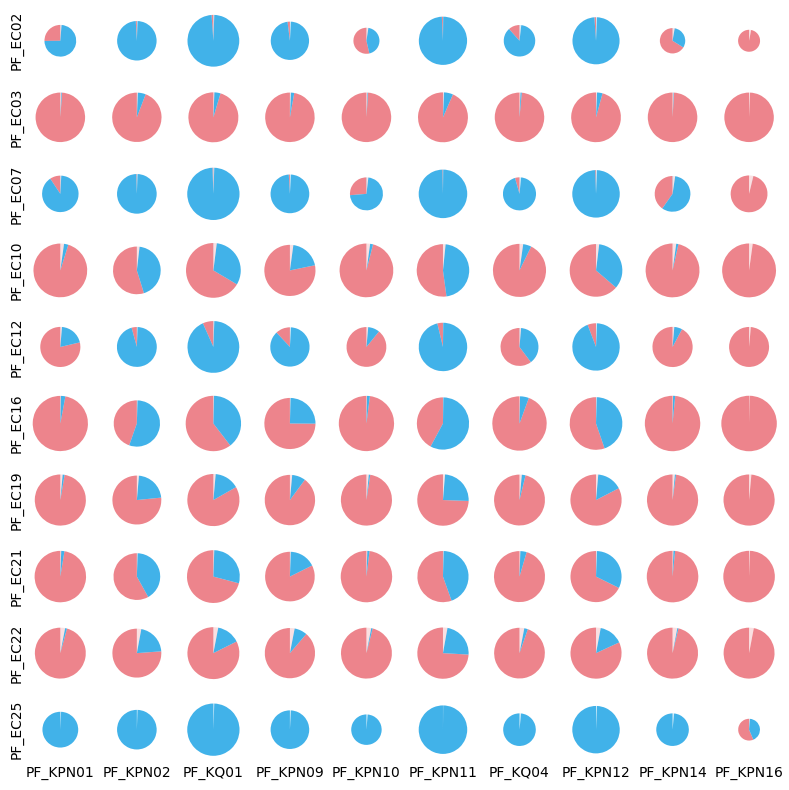

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	12.63	86.43	0.35	0.58
PF_EC02 vs PF_KPN02	0.24	99.21	0.00	0.55
PF_EC02 vs PF_KQ01	0.27	99.20	0.00	0.53
PF_EC02 vs PF_KPN09	0.73	98.42	0.01	0.84
PF_EC02 vs PF_KPN10	24.52	73.71	0.93	0.84
PF_EC02 vs PF_KPN11	0.18	99.66	0.00	0.15
PF_EC02 vs PF_KQ04	3.60	94.88	0.08	1.44
PF_EC02 vs PF_KPN12	0.39	98.95	0.00	0.65
PF_EC02 vs PF_KPN14	38.14	59.59	1.47	0.80
PF_EC02 vs PF_KPN16	96.88	0.00	3.12	0.00
PF_EC03 vs PF_KPN01	98.90	0.47	0.62	0.00
PF_EC03 vs PF_KPN02	89.38	10.00	0.60	0.03
PF_EC03 vs PF_KQ01	90.58	8.80	0.60	0.02
PF_EC03 vs PF_KPN09	96.58	2.79	0.62	0.01
PF_EC03 vs PF_KPN10	98.70	0.68	0.62	0.00
PF_EC03 vs PF_KPN11	86.11	13.29	0.58	0.02
PF_EC03 vs PF_KQ04	98.06	1.31	0.62	0.00
PF_EC03 vs PF_KPN12	94.47	4.91	0.61	0.01
PF_EC03 vs PF_KPN14	98.85	0.53	0.62	0.00
PF_EC03 vs PF_KPN16	99.38	0.00	0.62	0.00
PF_EC07 vs PF_KPN01	3.96	95.31	0.09	0.65
PF_EC07 vs PF_KPN02	0.13	99.33	0.00	0.55
PF_EC07 vs PF_KQ01	0.13	99.34	0.00	0.53
PF_EC07 vs PF_KPN09	0.33	98.

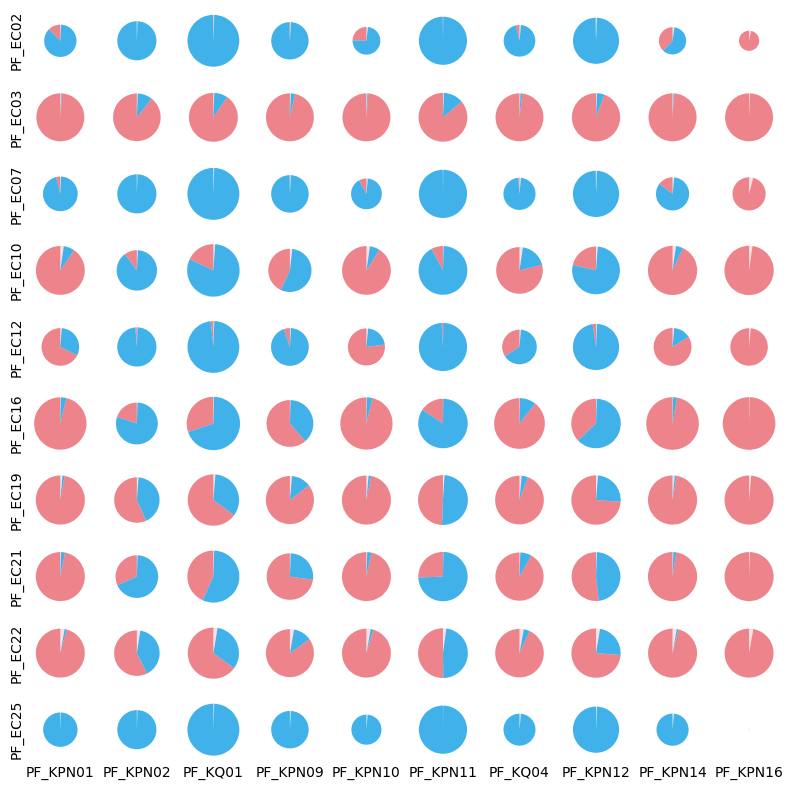

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	2.58	96.68	0.07	0.67
PF_EC02 vs PF_KPN02	0.02	99.45	0.00	0.53
PF_EC02 vs PF_KQ01	0.02	99.47	0.00	0.51
PF_EC02 vs PF_KPN09	0.10	99.06	0.00	0.85
PF_EC02 vs PF_KPN10	2.02	96.75	0.08	1.15
PF_EC02 vs PF_KPN11	0.01	99.84	0.00	0.15
PF_EC02 vs PF_KQ04	0.30	98.30	0.01	1.40
PF_EC02 vs PF_KPN12	0.05	99.30	0.00	0.66
PF_EC02 vs PF_KPN14	4.41	94.09	0.20	1.30
PF_EC02 vs PF_KPN16	95.93	0.00	4.07	0.00
PF_EC03 vs PF_KPN01	98.89	0.47	0.63	0.00
PF_EC03 vs PF_KPN02	68.61	30.77	0.52	0.10
PF_EC03 vs PF_KQ01	66.75	32.64	0.51	0.11
PF_EC03 vs PF_KPN09	94.75	4.62	0.62	0.01
PF_EC03 vs PF_KPN10	97.55	1.81	0.63	0.00
PF_EC03 vs PF_KPN11	54.21	45.30	0.43	0.06
PF_EC03 vs PF_KQ04	96.20	3.16	0.63	0.01
PF_EC03 vs PF_KPN12	90.15	9.21	0.60	0.03
PF_EC03 vs PF_KPN14	98.04	1.32	0.63	0.00
PF_EC03 vs PF_KPN16	99.37	0.00	0.63	0.00
PF_EC07 vs PF_KPN01	0.65	98.65	0.02	0.68
PF_EC07 vs PF_KPN02	0.01	99.46	0.00	0.53
PF_EC07 vs PF_KQ01	0.01	99.48	0.00	0.51
PF_EC07 vs PF_KPN09	0.04	99.11

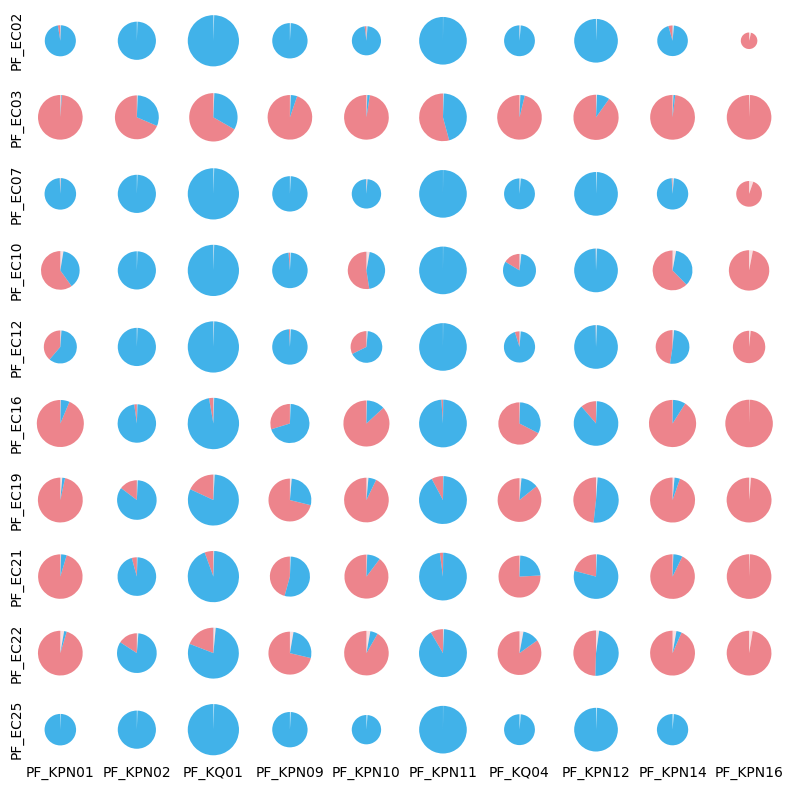

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	0.09	99.17	0.00	0.74
PF_EC02 vs PF_KPN02	0.00	99.46	0.00	0.54
PF_EC02 vs PF_KQ01	0.00	99.50	0.00	0.50
PF_EC02 vs PF_KPN09	0.00	98.99	0.00	1.01
PF_EC02 vs PF_KPN10	0.01	98.82	0.00	1.17
PF_EC02 vs PF_KPN11	0.00	99.85	0.00	0.15
PF_EC02 vs PF_KQ04	0.00	98.50	0.00	1.49
PF_EC02 vs PF_KPN12	0.00	99.25	0.00	0.75
PF_EC02 vs PF_KPN14	0.02	98.61	0.00	1.38
PF_EC02 vs PF_KPN16	91.39	0.00	8.61	0.00
PF_EC03 vs PF_KPN01	98.88	0.47	0.65	0.00
PF_EC03 vs PF_KPN02	9.70	89.75	0.09	0.46
PF_EC03 vs PF_KQ01	6.41	93.07	0.06	0.46
PF_EC03 vs PF_KPN09	87.24	12.08	0.61	0.07
PF_EC03 vs PF_KPN10	88.27	11.05	0.64	0.04
PF_EC03 vs PF_KPN11	1.90	97.94	0.02	0.14
PF_EC03 vs PF_KQ04	83.82	15.50	0.62	0.07
PF_EC03 vs PF_KPN12	71.43	27.89	0.53	0.16
PF_EC03 vs PF_KPN14	91.92	7.41	0.64	0.02
PF_EC03 vs PF_KPN16	99.35	0.00	0.65	0.00
PF_EC07 vs PF_KPN01	0.02	99.24	0.00	0.74
PF_EC07 vs PF_KPN02	0.00	99.46	0.00	0.54
PF_EC07 vs PF_KQ01	0.00	99.50	0.00	0.50
PF_EC07 vs PF_KPN09	0.00	98.9

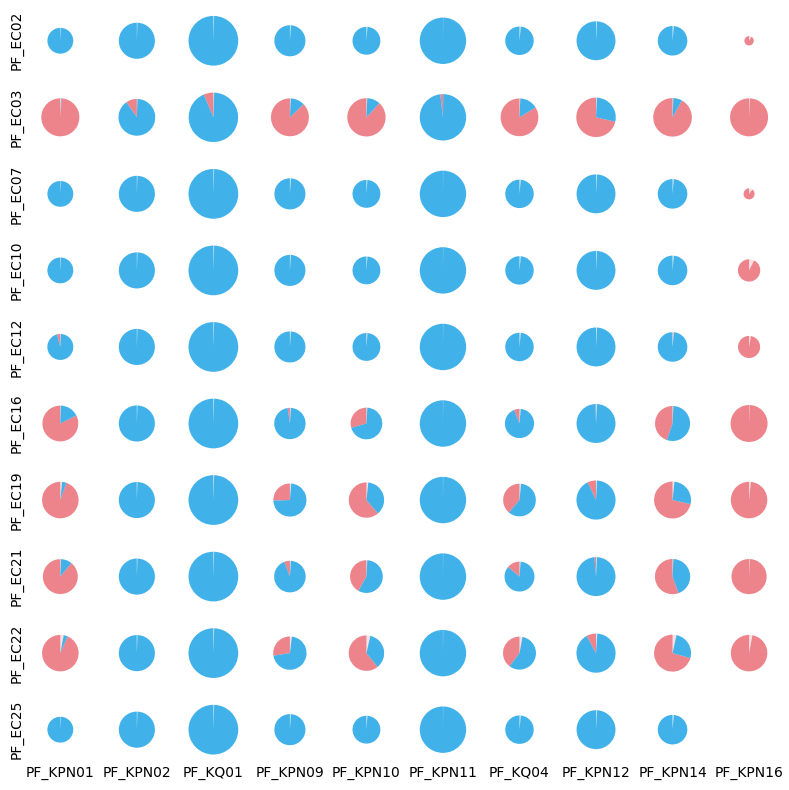

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	0.00	99.21	0.00	0.79
PF_EC02 vs PF_KPN02	0.00	99.44	0.00	0.56
PF_EC02 vs PF_KQ01	0.00	99.49	0.00	0.51
PF_EC02 vs PF_KPN09	0.00	97.28	0.00	2.72
PF_EC02 vs PF_KPN10	0.00	98.79	0.00	1.21
PF_EC02 vs PF_KPN11	0.00	99.85	0.00	0.15
PF_EC02 vs PF_KQ04	0.00	97.61	0.00	2.39
PF_EC02 vs PF_KPN12	0.00	98.12	0.00	1.88
PF_EC02 vs PF_KPN14	0.00	98.45	0.00	1.55
PF_EC02 vs PF_KPN16	82.71	0.14	17.15	0.00
PF_EC03 vs PF_KPN01	98.61	0.52	0.87	0.00
PF_EC03 vs PF_KPN02	0.00	99.43	0.00	0.56
PF_EC03 vs PF_KQ01	0.00	99.49	0.00	0.51
PF_EC03 vs PF_KPN09	41.56	56.53	0.37	1.54
PF_EC03 vs PF_KPN10	15.37	83.53	0.14	0.96
PF_EC03 vs PF_KPN11	0.00	99.85	0.00	0.15
PF_EC03 vs PF_KQ04	9.60	88.29	0.09	2.03
PF_EC03 vs PF_KPN12	9.45	88.75	0.08	1.72
PF_EC03 vs PF_KPN14	29.12	69.68	0.27	0.94
PF_EC03 vs PF_KPN16	99.13	0.00	0.87	0.00
PF_EC07 vs PF_KPN01	0.00	99.21	0.00	0.79
PF_EC07 vs PF_KPN02	0.00	99.44	0.00	0.56
PF_EC07 vs PF_KQ01	0.00	99.49	0.00	0.51
PF_EC07 vs PF_KPN09	0.00	97.2

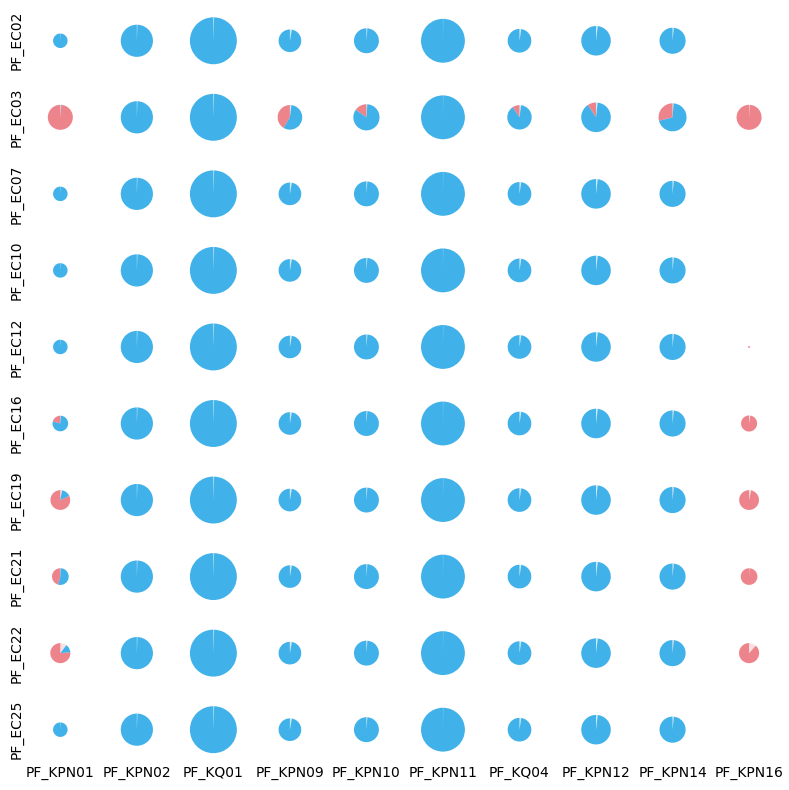

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	0.40	98.81	0.00	0.79
PF_EC02 vs PF_KPN02	0.00	99.22	0.00	0.78
PF_EC02 vs PF_KQ01	0.00	99.44	0.00	0.55
PF_EC02 vs PF_KPN09	0.00	63.61	0.00	36.39
PF_EC02 vs PF_KPN10	0.00	98.54	0.00	1.46
PF_EC02 vs PF_KPN11	0.00	99.84	0.00	0.16
PF_EC02 vs PF_KQ04	0.00	75.11	0.00	24.89
PF_EC02 vs PF_KPN12	0.00	65.83	0.00	34.17
PF_EC02 vs PF_KPN14	0.00	97.15	0.00	2.85
PF_EC02 vs PF_KPN16	89.37	10.16	0.31	0.16
PF_EC03 vs PF_KPN01	94.67	4.39	0.90	0.03
PF_EC03 vs PF_KPN02	0.00	99.22	0.00	0.78
PF_EC03 vs PF_KQ01	0.00	99.44	0.00	0.55
PF_EC03 vs PF_KPN09	0.02	63.60	0.00	36.38
PF_EC03 vs PF_KPN10	0.00	98.54	0.00	1.46
PF_EC03 vs PF_KPN11	0.00	99.84	0.00	0.16
PF_EC03 vs PF_KQ04	0.00	75.11	0.00	24.89
PF_EC03 vs PF_KPN12	0.00	65.83	0.00	34.17
PF_EC03 vs PF_KPN14	0.00	97.15	0.00	2.85
PF_EC03 vs PF_KPN16	99.05	0.00	0.94	0.00
PF_EC07 vs PF_KPN01	0.40	98.81	0.00	0.79
PF_EC07 vs PF_KPN02	0.00	99.22	0.00	0.78
PF_EC07 vs PF_KQ01	0.00	99.44	0.00	0.55
PF_EC07 vs PF_KPN09	0.00	6

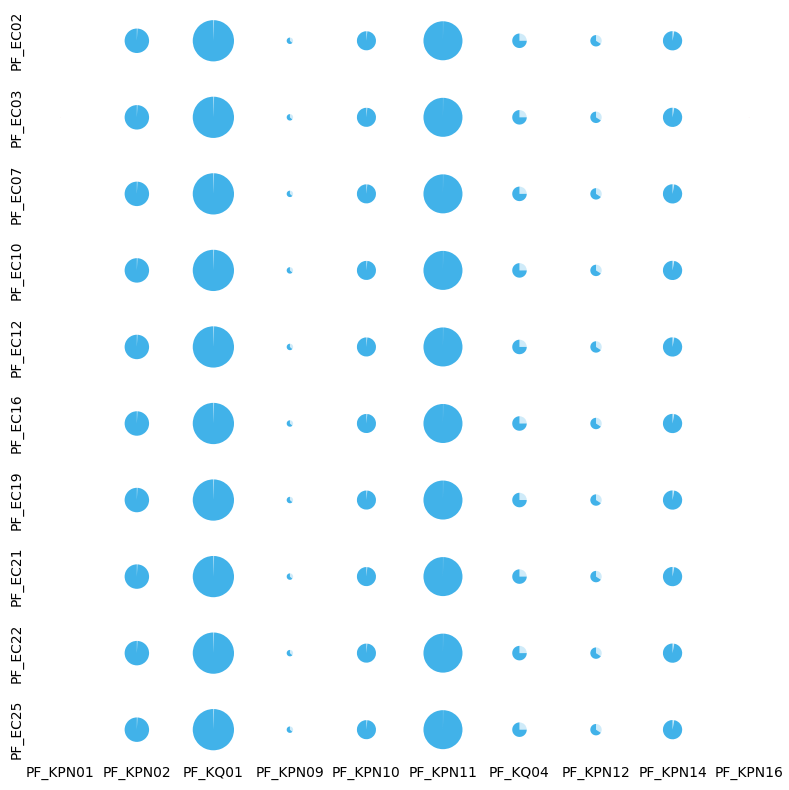

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	31.88	67.53	0.12	0.47
PF_EC02 vs PF_KPN02	0.00	97.89	0.00	2.11
PF_EC02 vs PF_KQ01	0.00	98.97	0.00	1.03
PF_EC02 vs PF_KPN09	31.41	68.01	0.12	0.47
PF_EC02 vs PF_KPN10	0.00	98.03	0.00	1.97
PF_EC02 vs PF_KPN11	0.00	99.78	0.00	0.22
PF_EC02 vs PF_KQ04	0.00	2.44	0.00	97.56
PF_EC02 vs PF_KPN12	31.26	68.14	0.12	0.49
PF_EC02 vs PF_KPN14	0.00	84.83	0.00	15.17
PF_EC02 vs PF_KPN16	88.89	10.61	0.33	0.16
PF_EC03 vs PF_KPN01	32.65	66.82	0.06	0.47
PF_EC03 vs PF_KPN02	0.00	97.89	0.00	2.11
PF_EC03 vs PF_KQ01	0.00	98.97	0.00	1.03
PF_EC03 vs PF_KPN09	32.18	67.31	0.06	0.46
PF_EC03 vs PF_KPN10	0.00	98.03	0.00	1.97
PF_EC03 vs PF_KPN11	0.00	99.78	0.00	0.22
PF_EC03 vs PF_KQ04	0.00	2.44	0.00	97.56
PF_EC03 vs PF_KPN12	32.02	67.43	0.06	0.49
PF_EC03 vs PF_KPN14	0.00	84.83	0.00	15.17
PF_EC03 vs PF_KPN16	89.37	10.31	0.16	0.16
PF_EC07 vs PF_KPN01	31.77	67.52	0.24	0.47
PF_EC07 vs PF_KPN02	0.00	97.89	0.00	2.11
PF_EC07 vs PF_KQ01	0.00	98.97	0.00	1.03
PF_EC07 vs PF_KPN09	31

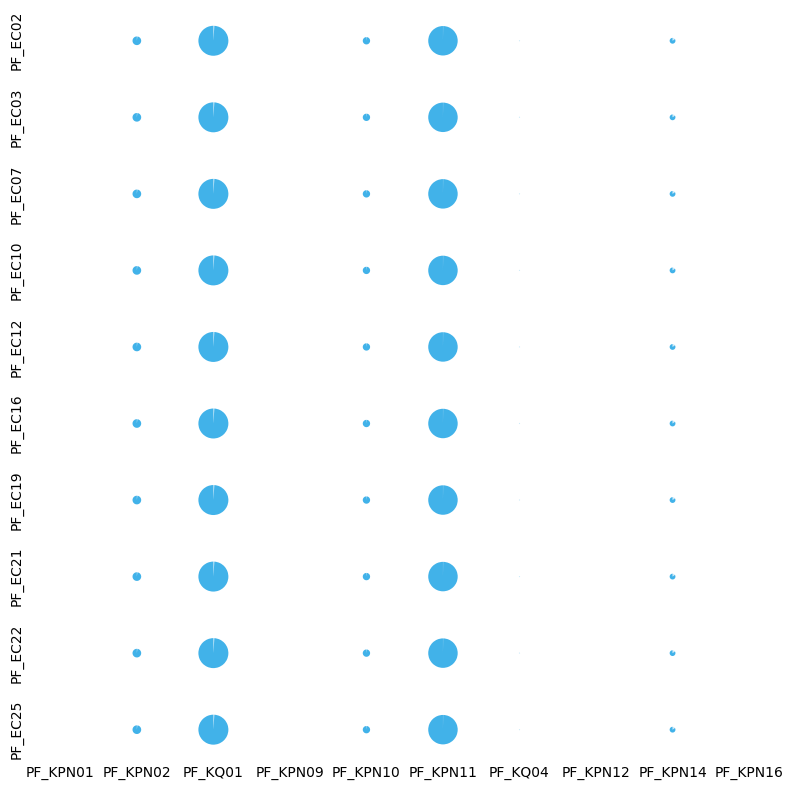

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	32.53	66.86	0.12	0.49
PF_EC02 vs PF_KPN02	18.22	81.58	0.07	0.14
PF_EC02 vs PF_KQ01	0.00	88.11	0.00	11.89
PF_EC02 vs PF_KPN09	32.30	67.08	0.12	0.49
PF_EC02 vs PF_KPN10	4.05	94.71	0.02	1.23
PF_EC02 vs PF_KPN11	0.00	99.44	0.00	0.56
PF_EC02 vs PF_KQ04	18.60	81.19	0.07	0.14
PF_EC02 vs PF_KPN12	32.23	67.15	0.12	0.49
PF_EC02 vs PF_KPN14	6.59	86.27	0.03	7.11
PF_EC02 vs PF_KPN16	88.66	10.84	0.34	0.17
PF_EC03 vs PF_KPN01	32.91	66.53	0.06	0.49
PF_EC03 vs PF_KPN02	18.47	81.36	0.03	0.14
PF_EC03 vs PF_KQ01	0.00	88.11	0.00	11.89
PF_EC03 vs PF_KPN09	32.69	66.76	0.06	0.49
PF_EC03 vs PF_KPN10	4.11	94.65	0.01	1.23
PF_EC03 vs PF_KPN11	0.00	99.44	0.00	0.56
PF_EC03 vs PF_KQ04	18.86	80.96	0.04	0.14
PF_EC03 vs PF_KPN12	32.62	66.83	0.06	0.49
PF_EC03 vs PF_KPN14	6.70	86.19	0.01	7.10
PF_EC03 vs PF_KPN16	88.97	10.70	0.17	0.17
PF_EC07 vs PF_KPN01	32.45	66.81	0.25	0.49
PF_EC07 vs PF_KPN02	18.18	81.55	0.14	0.14
PF_EC07 vs PF_KQ01	0.00	88.11	0.00	11.89
PF_EC07 vs PF_KP

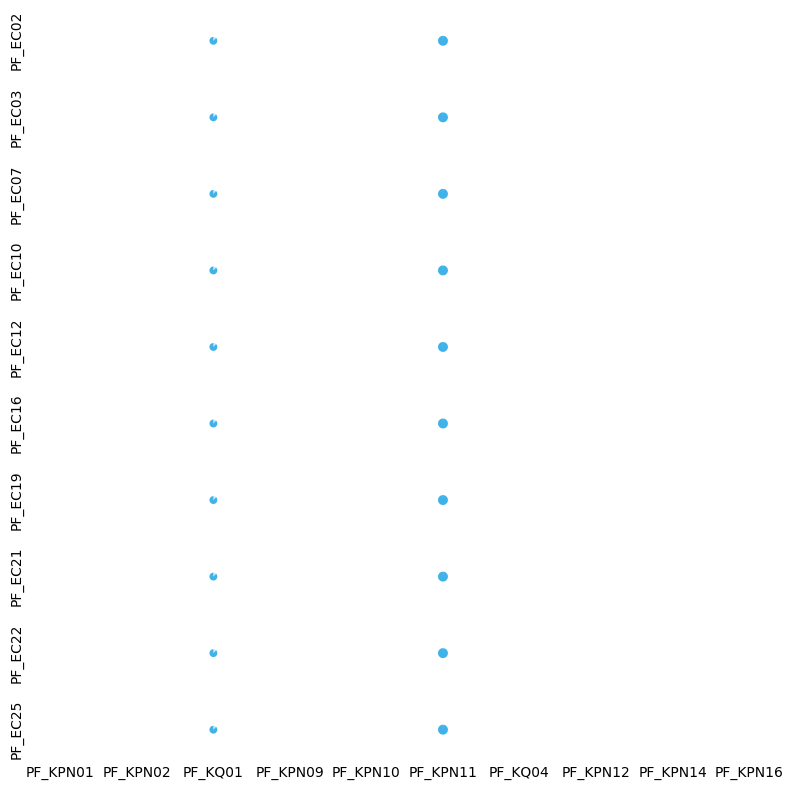

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	32.83	66.54	0.13	0.51
PF_EC02 vs PF_KPN02	19.12	80.66	0.07	0.15
PF_EC02 vs PF_KQ01	9.96	89.85	0.04	0.15
PF_EC02 vs PF_KPN09	32.72	66.65	0.13	0.50
PF_EC02 vs PF_KPN10	10.27	89.61	0.04	0.08
PF_EC02 vs PF_KPN11	9.89	89.77	0.04	0.31
PF_EC02 vs PF_KQ04	19.30	80.48	0.07	0.15
PF_EC02 vs PF_KPN12	32.69	66.68	0.13	0.50
PF_EC02 vs PF_KPN14	10.30	89.58	0.04	0.08
PF_EC02 vs PF_KPN16	88.54	10.95	0.34	0.17
PF_EC03 vs PF_KPN01	33.03	66.40	0.06	0.51
PF_EC03 vs PF_KPN02	19.25	80.57	0.04	0.15
PF_EC03 vs PF_KQ01	10.03	89.79	0.02	0.15
PF_EC03 vs PF_KPN09	32.92	66.51	0.06	0.50
PF_EC03 vs PF_KPN10	10.35	89.56	0.02	0.08
PF_EC03 vs PF_KPN11	9.97	89.71	0.02	0.31
PF_EC03 vs PF_KQ04	19.44	80.38	0.04	0.15
PF_EC03 vs PF_KPN12	32.89	66.54	0.06	0.50
PF_EC03 vs PF_KPN14	10.37	89.53	0.02	0.08
PF_EC03 vs PF_KPN16	88.77	10.89	0.17	0.17
PF_EC07 vs PF_KPN01	32.77	66.47	0.25	0.51
PF_EC07 vs PF_KPN02	19.09	80.62	0.15	0.15
PF_EC07 vs PF_KQ01	9.95	89.82	0.08	0.15
PF_EC07 vs PF_

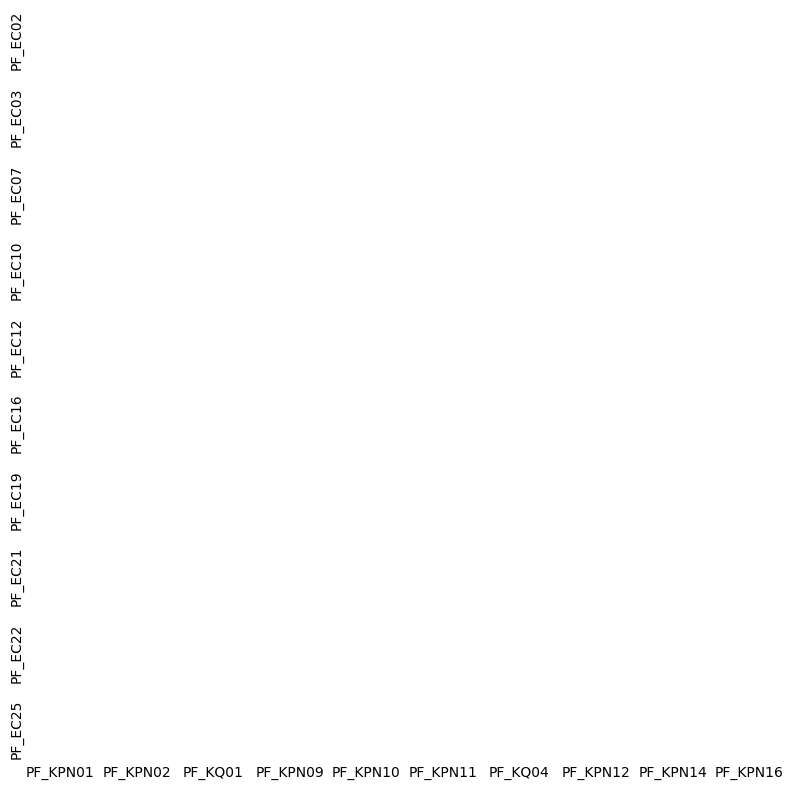

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	32.98	66.38	0.13	0.51
PF_EC02 vs PF_KPN02	19.55	80.22	0.08	0.15
PF_EC02 vs PF_KQ01	10.53	89.26	0.04	0.16
PF_EC02 vs PF_KPN09	32.93	66.43	0.13	0.51
PF_EC02 vs PF_KPN10	10.69	89.18	0.04	0.08
PF_EC02 vs PF_KPN11	10.49	89.14	0.04	0.33
PF_EC02 vs PF_KQ04	19.64	80.13	0.08	0.15
PF_EC02 vs PF_KPN12	32.91	66.45	0.13	0.51
PF_EC02 vs PF_KPN14	10.71	89.17	0.04	0.08
PF_EC02 vs PF_KPN16	88.48	11.00	0.34	0.17
PF_EC03 vs PF_KPN01	33.09	66.33	0.06	0.51
PF_EC03 vs PF_KPN02	19.62	80.19	0.04	0.15
PF_EC03 vs PF_KQ01	10.57	89.24	0.02	0.16
PF_EC03 vs PF_KPN09	33.04	66.39	0.06	0.51
PF_EC03 vs PF_KPN10	10.73	89.16	0.02	0.08
PF_EC03 vs PF_KPN11	10.53	89.12	0.02	0.33
PF_EC03 vs PF_KQ04	19.71	80.10	0.04	0.15
PF_EC03 vs PF_KPN12	33.02	66.40	0.06	0.51
PF_EC03 vs PF_KPN14	10.75	89.15	0.02	0.08
PF_EC03 vs PF_KPN16	88.67	10.99	0.17	0.17
PF_EC07 vs PF_KPN01	32.93	66.30	0.26	0.51
PF_EC07 vs PF_KPN02	19.52	80.17	0.15	0.15
PF_EC07 vs PF_KQ01	10.53	89.23	0.08	0.16
PF_EC07 vs

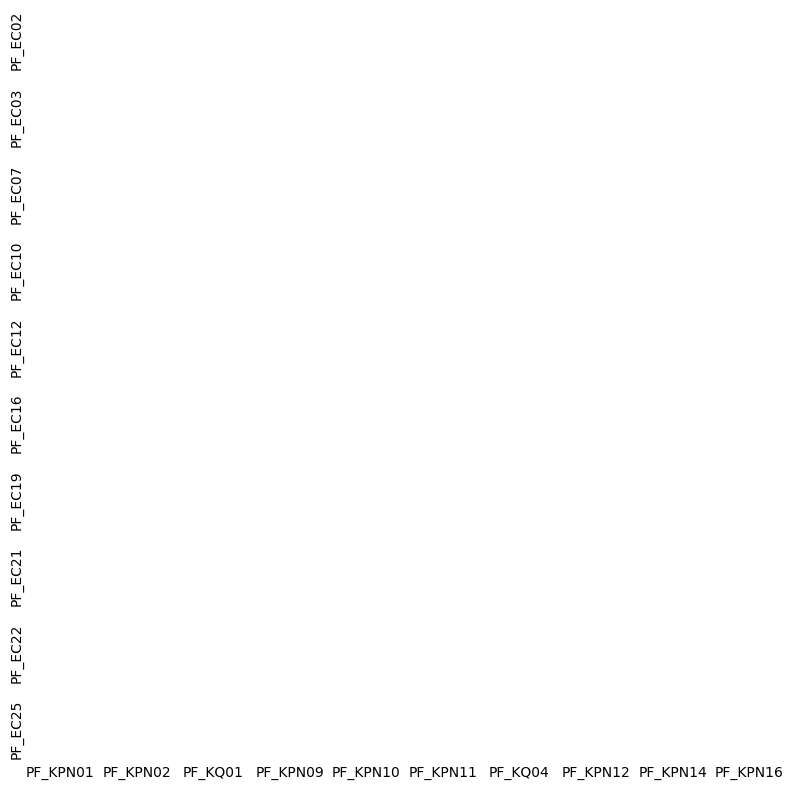

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	33.05	66.30	0.13	0.51
PF_EC02 vs PF_KPN02	19.76	80.01	0.08	0.15
PF_EC02 vs PF_KQ01	10.82	88.97	0.04	0.17
PF_EC02 vs PF_KPN09	33.03	66.33	0.13	0.51
PF_EC02 vs PF_KPN10	10.90	88.97	0.04	0.08
PF_EC02 vs PF_KPN11	10.78	88.84	0.04	0.34
PF_EC02 vs PF_KQ04	19.81	79.96	0.08	0.15
PF_EC02 vs PF_KPN12	33.02	66.34	0.13	0.51
PF_EC02 vs PF_KPN14	10.91	88.97	0.04	0.08
PF_EC02 vs PF_KPN16	88.45	11.03	0.34	0.17
PF_EC03 vs PF_KPN01	33.12	66.30	0.06	0.51
PF_EC03 vs PF_KPN02	19.80	80.01	0.04	0.15
PF_EC03 vs PF_KQ01	10.84	88.97	0.02	0.17
PF_EC03 vs PF_KPN09	33.09	66.33	0.06	0.51
PF_EC03 vs PF_KPN10	10.92	88.97	0.02	0.08
PF_EC03 vs PF_KPN11	10.81	88.84	0.02	0.34
PF_EC03 vs PF_KQ04	19.84	79.96	0.04	0.15
PF_EC03 vs PF_KPN12	33.09	66.34	0.06	0.51
PF_EC03 vs PF_KPN14	10.93	88.97	0.02	0.08
PF_EC03 vs PF_KPN16	88.62	11.03	0.17	0.17
PF_EC07 vs PF_KPN01	33.01	66.22	0.26	0.51
PF_EC07 vs PF_KPN02	19.74	79.95	0.15	0.15
PF_EC07 vs PF_KQ01	10.81	88.94	0.08	0.17
PF_EC07 vs

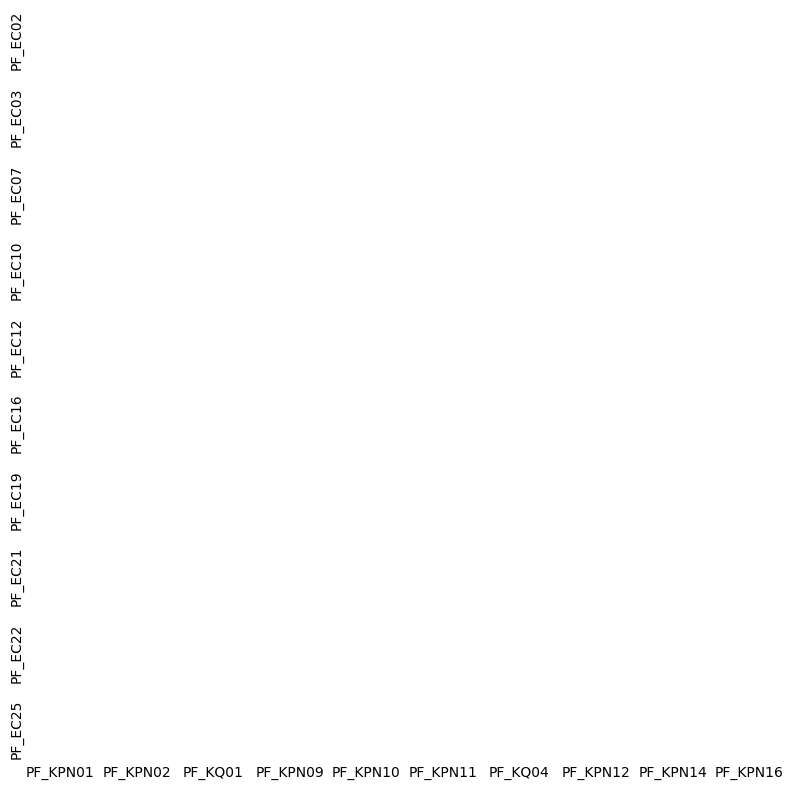

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	33.09	66.27	0.13	0.52
PF_EC02 vs PF_KPN02	19.87	79.90	0.08	0.15
PF_EC02 vs PF_KQ01	10.96	88.83	0.04	0.17
PF_EC02 vs PF_KPN09	33.08	66.28	0.13	0.52
PF_EC02 vs PF_KPN10	11.00	88.87	0.04	0.09
PF_EC02 vs PF_KPN11	10.93	88.69	0.04	0.34
PF_EC02 vs PF_KQ04	19.89	79.88	0.08	0.16
PF_EC02 vs PF_KPN12	33.07	66.28	0.13	0.52
PF_EC02 vs PF_KPN14	11.01	88.86	0.04	0.09
PF_EC02 vs PF_KPN16	88.44	11.04	0.35	0.17
PF_EC03 vs PF_KPN01	33.13	66.29	0.06	0.52
PF_EC03 vs PF_KPN02	19.89	79.92	0.04	0.15
PF_EC03 vs PF_KQ01	10.97	88.84	0.02	0.17
PF_EC03 vs PF_KPN09	33.12	66.30	0.06	0.52
PF_EC03 vs PF_KPN10	11.01	88.88	0.02	0.09
PF_EC03 vs PF_KPN11	10.94	88.70	0.02	0.34
PF_EC03 vs PF_KQ04	19.91	79.90	0.04	0.15
PF_EC03 vs PF_KPN12	33.12	66.30	0.06	0.52
PF_EC03 vs PF_KPN14	11.02	88.87	0.02	0.09
PF_EC03 vs PF_KPN16	88.60	11.05	0.17	0.17
PF_EC07 vs PF_KPN01	33.05	66.18	0.26	0.52
PF_EC07 vs PF_KPN02	19.85	79.84	0.15	0.15
PF_EC07 vs PF_KQ01	10.95	88.79	0.09	0.17
PF_EC07 vs

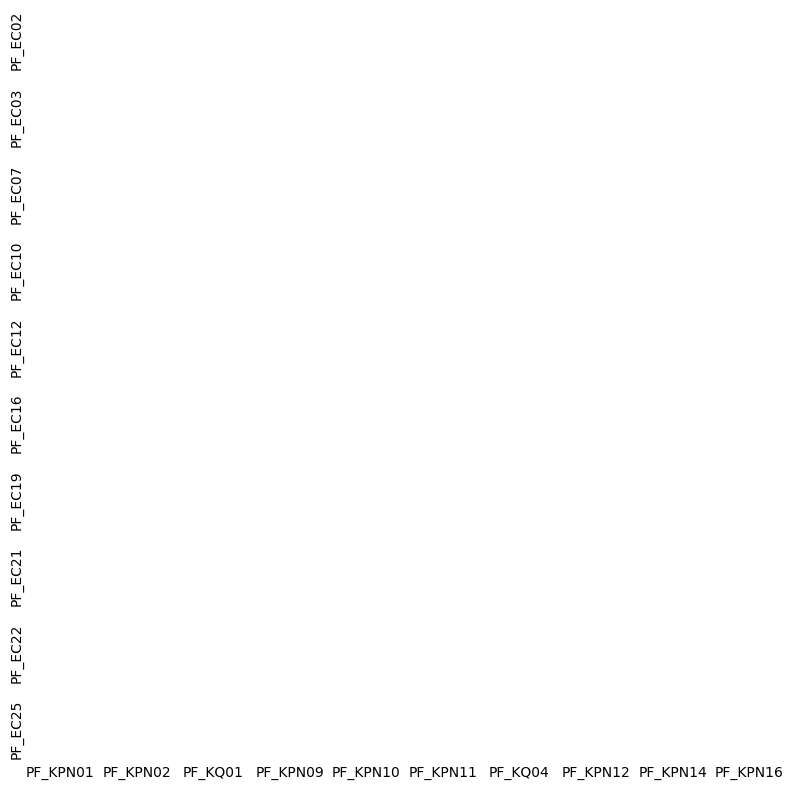

			Ec-Bp	Kpn-Bp	Ec-B0	Kpn-B0
PF_EC02 vs PF_KPN01	33.11	66.25	0.13	0.52
PF_EC02 vs PF_KPN02	19.92	79.85	0.08	0.16
PF_EC02 vs PF_KQ01	11.02	88.76	0.04	0.17
PF_EC02 vs PF_KPN09	33.10	66.25	0.13	0.52
PF_EC02 vs PF_KPN10	11.06	88.81	0.04	0.09
PF_EC02 vs PF_KPN11	11.00	88.61	0.04	0.34
PF_EC02 vs PF_KQ04	19.93	79.84	0.08	0.16
PF_EC02 vs PF_KPN12	33.10	66.25	0.13	0.52
PF_EC02 vs PF_KPN14	11.06	88.81	0.04	0.09
PF_EC02 vs PF_KPN16	88.43	11.05	0.35	0.17
PF_EC03 vs PF_KPN01	33.14	66.28	0.06	0.52
PF_EC03 vs PF_KPN02	19.94	79.87	0.04	0.16
PF_EC03 vs PF_KQ01	11.03	88.78	0.02	0.17
PF_EC03 vs PF_KPN09	33.13	66.28	0.06	0.52
PF_EC03 vs PF_KPN10	11.06	88.83	0.02	0.09
PF_EC03 vs PF_KPN11	11.01	88.63	0.02	0.34
PF_EC03 vs PF_KQ04	19.94	79.86	0.04	0.16
PF_EC03 vs PF_KPN12	33.13	66.29	0.06	0.52
PF_EC03 vs PF_KPN14	11.06	88.83	0.02	0.09
PF_EC03 vs PF_KPN16	88.59	11.07	0.17	0.17
PF_EC07 vs PF_KPN01	33.07	66.16	0.26	0.52
PF_EC07 vs PF_KPN02	19.90	79.79	0.16	0.16
PF_EC07 vs PF_KQ01	11.02	88.72	0.09	0.17
PF_EC07 vs

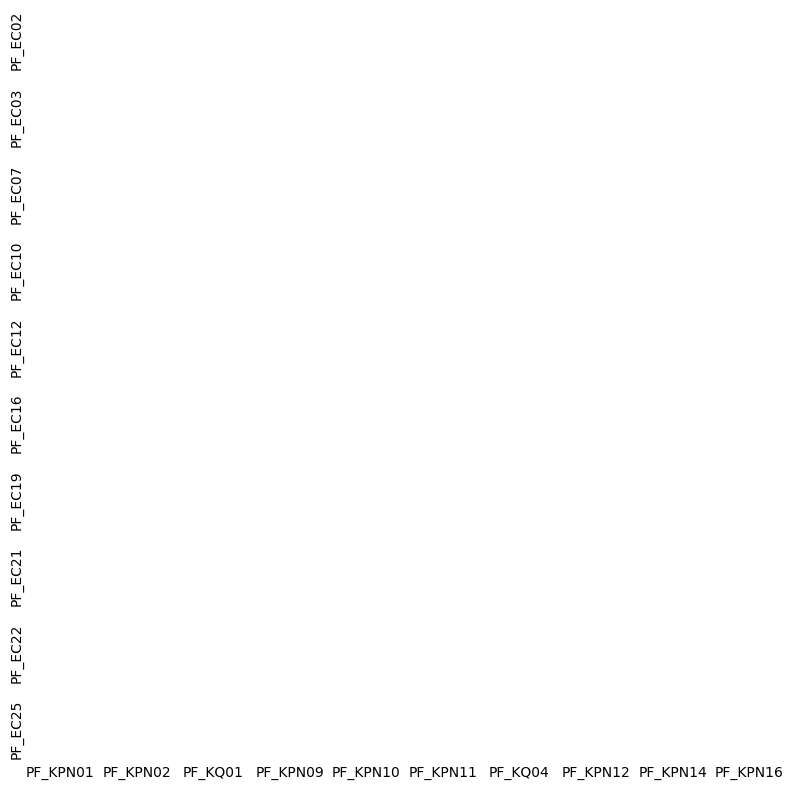

In [13]:



for iA, results_A in sim_df.items():
    print("\t\t\tEc-Bp\tKpn-Bp\tEc-B0\tKpn-B0")
    fig, axs = plt.subplots(len(strains_subsetE), len(strains_subsetK), figsize=(8,8))


    for results_inner in results_A:  # These are the lists inside results_A
        for result in results_inner:  # These are the individual tuples
            final_densities, strain1, strain2 = result
            i = strains_subsetE.index(strain1)
            j = strains_subsetK.index(strain2)
            ax = axs[i, j]
            print(strain_namesE[i], 'vs', strain_namesK[j], end='')

            # Assign colors based on strain type
            color_strains = [red, blue, red, blue]
            if np.sum(final_densities)>expe_params['extinction_threshold']:
              plot_popStructure_species(final_densities, max_density, color_strains, ax)
            else:
              ax.axis('off')

            if i==len(strains_subsetK)-1:
              ax.set_xlabel(strain_namesK[j])
            if j==0:
              ax.set_ylabel(strain_namesE[i])
    plt.tight_layout()


    figPathN="%sN%s/"%(figPath, num_days)
    if not os.path.exists(figPathN):
        os.makedirs(figPathN)
    strain_path="%spairwise_pecies_N%s_A%se-2.pdf"%(figPathN, num_days, Amax_values[iA]*100)
    print("Exporting %s"%strain_path)
    plt.savefig(strain_path)


    plt.show()

In [14]:
def compute_pairwiseStability(sim_df, strains_subset, As):
    extinction_threshold = expe_params['extinction_threshold']
    percentages0 = []
    percentages1 = []
    percentagesTot = []
    for A in As:
        subset_data = sim_df[sim_df['A'] == A]
        stable_count0 = 0
        stable_count1 = 0
        stable_countTot = 0
        total_count = 0
        for _, row in subset_data.iterrows():

            plasmid_fraction = row['PlasmidFraction']
            strain1 = row['Strain1']
            strain2 = row['Strain2']


            if strain1 in strains_subset or strain2 in strains_subset:
                pf0=plasmid_fraction[0]
                pf1=plasmid_fraction[1]
                pfTot=plasmid_fraction[0]+plasmid_fraction[1]

                total_count += 1

                if pf0 > extinction_threshold:
                  stable_count0 += 1
                if pf1 > extinction_threshold:
                  stable_count1 += 1
                if pfTot > extinction_threshold:
                  stable_countTot += 1

                #print('(',stable_count0,',',stable_count1,',',stable_countTot,') /', total_count,' \t ', strain1, 'VKm',strain2,' \t ',  pf0, pf1, pfTot)

        percentage0 = (stable_count0 / total_count) * 100 if total_count > 0 else 0
        percentage1 = (stable_count1 / total_count) * 100 if total_count > 0 else 0
        percentageTot = (stable_countTot / total_count) * 100 if total_count > 0 else 0

        percentages0.append(percentage0)
        percentages1.append(percentage1)
        percentagesTot.append(percentageTot)

    return np.array(percentages0),np.array(percentages1),np.array(percentagesTot)

